In [1]:
from EmuLP import Cosmology, Filter, Galaxy, Estimator, Extinction, Template, Analysis

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax_cosmo as jc
import jax.numpy as jnp
from jax import vmap, jit
import json, pickle
import os,sys,copy
from tqdm import tqdm
from collections import namedtuple

from scipy.interpolate import interp1d
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline as j_spline

2023-11-21 10:23:28.172579: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [3]:
ref_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-togglePriorTrue-opa-fullAnalysis.json' # attention à la localisation du fichier !
test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTemp_priorEBV_noTypeNoLaw.json' # attention à la localisation du fichier !
#conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-dustSelTemp_priorEBV.json' # attention à la localisation du fichier !
ref_inputs = Analysis.json_to_inputs(ref_json)
test_inputs = Analysis.json_to_inputs(test_conf_json)

In [4]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [5]:
cosmo_ref, z_grid_ref, fine_z_grid_ref, wl_grid_ref, filters_arr_ref, named_filts_ref, baseTemp_arr_ref, extlaws_dict_ref,\
ebv_vals_ref, dust_arr_ref, wls_opa_ref, opa_zgrid_ref, opacity_grid_ref, obs_arr_ref = Analysis.load_data_for_analysis(os.path.basename(ref_json))

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 66.12it/s]


Building templates :


100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


Generating dust attenuations laws :


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1023.01it/s]


In [6]:
cosmo_test, z_grid_test, fine_z_grid_test, wl_grid_test, filters_arr_test, named_filts_test, baseTemp_arr_test, extlaws_dict_test,\
ebv_vals_test, dust_arr_test, wls_opa_test, opa_zgrid_test, opacity_grid_test, obs_arr_test = Analysis.load_data_for_analysis(os.path.basename(test_conf_json))

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 79.08it/s]


Building templates :


100%|██████████| 29/29 [00:02<00:00, 10.40it/s]


Generating dust attenuations laws :


100%|██████████| 10/10 [00:00<00:00, 259.61it/s]

100%|██████████| 2/2 [00:00<00:00, 23.51it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1427.55it/s]


In [7]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [8]:
df_ref_emulp = pd.read_pickle(f"{ref_inputs['run name']}_results_summary.pkl")
df_ref_emulp

Id  Photometric redshift  True redshift   Template SED  \
0      362.0                  0.61         0.6636   CWW_Im-id546   
1     8353.0                  0.27         0.2819  CWW_Scd-id354   
2     7547.0                  0.21         0.2215   CWW_Im-id537   
3    10402.0                  0.65         0.6595   CWW_Im-id113   
4    12425.0                  1.35         1.0201  CWW_Scd-id532   
..       ...                   ...            ...            ...   
995   5756.0                  2.45         2.6639   CWW_Im-id699   
996  16455.0                  0.73         0.7336    CWW_E-id235   
997  13692.0                  0.63         0.9258  CWW_Scd-id268   
998   3751.0                  0.87         0.8700   CWW_Im-id113   
999   1602.0                  1.03         1.1173   CWW_Im-id113   

    Extinction law  E(B-V)        Chi2 Highest evidence SED  \
0           Prevot    0.25   22.885651         CWW_Im-id546   
1         Calzetti    0.15  124.263847        CWW_Scd-id354   
2           Prevot    0.20   73.361610         CWW_Im-id537   
3           Prevot    0.20   16.253048         CWW_Im-id113   
4           Prevot    0.20   25.719025        CWW_Scd-id532   
..             ...     ...         ...                  ...   
995       Calzetti    0.30   27.289156         CWW_Im-id265   
996       Calzetti    0.10    6.527909          CWW_E-id235   
997         Prevot    0.05   24.314442        CWW_Scd-id268   
998         Prevot    0.15   30.635420         CWW_Im-id113   
999         Prevot    0.05   17.911985         CWW_Im-id113   

    Highest evidence dust law  Highest evidence E(B-V)  \
0                      Prevot                     0.25   
1                    Calzetti                     0.15   
2                      Prevot                     0.20   
3                      Prevot                     0.20   
4                      Prevot                     0.20   
..                        ...                      ...   
995                    Prevot                     0.10   
996                  Calzetti                     0.10   
997                    Prevot                     0.05   
998                    Prevot                     0.15   
999                    Prevot                     0.05   

     Highest evidence odd ratio  Highest evidence z_phot (mode)  \
0                      1.000000                            0.61   
1                      1.000000                            0.27   
2                      1.000000                            0.21   
3                      1.000000                            0.65   
4                      1.000000                            1.35   
..                          ...                             ...   
995                    1.026272                            2.35   
996                    1.000000                            0.73   
997                    1.000000                            0.63   
998                    1.000000                            0.87   
999                    1.000000                            1.03   

     Highest evidence z_phot (mean)  Highest evidence sigma(z)  \
0                          0.613186                   0.000299   
1                          0.269855                   0.000003   
2                          0.211476                   0.000032   
3                          0.644358                   0.000396   
4                          1.346265                   0.000578   
..                              ...                        ...   
995                        2.377516                   0.003181   
996                        0.731324                   0.000025   
997                        0.630095                   0.000112   
998                        0.859542                   0.000266   
999                        1.023042                   0.000239   

    Best SED at z_spec Best dust law at z_spec  E(B-V) at z_spec  \
0         CWW_Im-id546                  Prevot              0.25   
1    

In [9]:
df_test_emulp = pd.read_pickle(f"{test_inputs['run name']}_results_summary.pkl")
df_test_emulp

Id  Photometric redshift  True redshift   Template SED  \
0      362.0                  0.61         0.6636   CWW_Im-id546   
1     8353.0                  0.27         0.2819  CWW_Scd-id354   
2     7547.0                  0.21         0.2215   CWW_Im-id537   
3    10402.0                  0.65         0.6595   CWW_Im-id113   
4    12425.0                  1.35         1.0201  CWW_Scd-id532   
..       ...                   ...            ...            ...   
995   5756.0                  2.35         2.6639   CWW_Im-id265   
996  16455.0                  0.73         0.7336    CWW_E-id235   
997  13692.0                  0.63         0.9258  CWW_Scd-id268   
998   3751.0                  0.87         0.8700   CWW_Im-id113   
999   1602.0                  1.03         1.1173   CWW_Im-id113   

    Extinction law  E(B-V)        Chi2 Highest evidence SED  \
0           Prevot    0.25   20.912914         CWW_Im-id546   
1         Calzetti    0.15  122.422340        CWW_Scd-id354   
2           Prevot    0.20   70.900551         CWW_Im-id537   
3           Prevot    0.20   13.791986         CWW_Im-id113   
4           Prevot    0.20   23.257961        CWW_Scd-id532   
..             ...     ...         ...                  ...   
995         Prevot    0.10   25.361845         CWW_Im-id265   
996       Calzetti    0.10    4.324327          CWW_E-id235   
997         Prevot    0.05   21.110231        CWW_Scd-id268   
998         Prevot    0.15   28.793911         CWW_Im-id113   
999         Prevot    0.05   14.707774         CWW_Im-id113   

    Highest evidence dust law  Highest evidence E(B-V)  \
0                      Prevot                     0.25   
1                    Calzetti                     0.15   
2                      Prevot                     0.20   
3                      Prevot                     0.20   
4                      Prevot                     0.20   
..                        ...                      ...   
995                    Prevot                     0.10   
996                  Calzetti                     0.10   
997                    Prevot                     0.05   
998                    Prevot                     0.15   
999                    Prevot                     0.05   

     Highest evidence odd ratio  Highest evidence z_phot (mode)  \
0                           1.0                            0.61   
1                           1.0                            0.27   
2                           1.0                            0.21   
3                           1.0                            0.65   
4                           1.0                            1.35   
..                          ...                             ...   
995                         1.0                            2.35   
996                         1.0                            0.73   
997                         1.0                            0.63   
998                         1.0                            0.87   
999                         1.0                            1.03   

     Highest evidence z_phot (mean)  Highest evidence sigma(z)  \
0                          0.613186                   0.000299   
1                          0.269855                   0.000003   
2                          0.211476                   0.000032   
3                          0.644358                   0.000396   
4                          1.346265                   0.000578   
..                              ...                        ...   
995                        2.377516                   0.003181   
996                        0.731324                   0.000025   
997                        0.630095                   0.000112   
998                        0.859542                   0.000266   
999                        1.023042                   0.000239   

    Best SED at z_spec Best dust law at z_spec  E(B-V) at z_spec  \
0         CWW_Im-id546                  Prevot              0.25   
1    

In [10]:
df_ref_more, outl_rate_ref, NMAD_ref = Analysis.results_in_dataframe(ref_json, obs_arr_ref, named_filts_ref)
df_ref_more

100%|██████████| 1000/1000 [00:19<00:00, 50.84it/s]


Outlier rate = 12.8257% ; NMAD = 0.06142


Id  Photometric redshift  True redshift   Template SED  \
0      362.0                  0.61         0.6636   CWW_Im-id546   
1     8353.0                  0.27         0.2819  CWW_Scd-id354   
2     7547.0                  0.21         0.2215   CWW_Im-id537   
3    10402.0                  0.65         0.6595   CWW_Im-id113   
4    12425.0                  1.35         1.0201  CWW_Scd-id532   
..       ...                   ...            ...            ...   
995   5756.0                  2.45         2.6639   CWW_Im-id699   
996  16455.0                  0.73         0.7336    CWW_E-id235   
997  13692.0                  0.63         0.9258  CWW_Scd-id268   
998   3751.0                  0.87         0.8700   CWW_Im-id113   
999   1602.0                  1.03         1.1173   CWW_Im-id113   

    Extinction law  E(B-V)        Chi2 Highest evidence SED  \
0           Prevot    0.25   22.885651         CWW_Im-id546   
1         Calzetti    0.15  124.263847        CWW_Scd-id354   
2           Prevot    0.20   73.361610         CWW_Im-id537   
3           Prevot    0.20   16.253048         CWW_Im-id113   
4           Prevot    0.20   25.719025        CWW_Scd-id532   
..             ...     ...         ...                  ...   
995       Calzetti    0.30   27.289156         CWW_Im-id265   
996       Calzetti    0.10    6.527909          CWW_E-id235   
997         Prevot    0.05   24.314442        CWW_Scd-id268   
998         Prevot    0.15   30.635420         CWW_Im-id113   
999         Prevot    0.05   17.911985         CWW_Im-id113   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
0                      Prevot                     0.25  ...        21.724495   
1                    Calzetti                     0.15  ...        19.593529   
2                      Prevot                     0.20  ...        20.448967   
3                      Prevot                     0.20  ...        22.066360   
4                      Prevot                     0.20  ...        23.027916   
..                        ...                      ...  ...              ...   
995                    Prevot                     0.10  ...        23.831917   
996                  Calzetti                     0.10  ...        20.603783   
997                    Prevot                     0.05  ...        21.630302   
998                    Prevot                     0.15  ...        21.752357   
999                    Prevot                     0.05  ...        22.431557   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
0               0.005330        21.681114             0.006234   
1               0.002292        19.379829             0.002413   
2               0.003380        20.397652             0.003857   
3               0.007630        21.858215             0.008252   
4               0.011093        22.694069             0.011409   
..                   ...              ...                  ...   
995             0.014877        23.791687             0.019078   
996             0.003643        20.173088             0.003468   
997             0.005108        21.311661             0.005163   
998             0.005474        21.451469             0.005597   
999             0.007169        22.034317             0.007080   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)          Bias  Outlier       U-B  \
0         21.581612            0.007518 -5.360005e-02    False  0.455261   
1         19.226929            0.002557 -1.190002e-02    False  0.858223   
2         20.312340            0.004316 -1.150001e-02    False  0.732582   
3         21.678215            0.009633 -9.500024e-03    False  0.587463   
4         22.185799            0.011367  3.298999e-01     True  0.492928   
..              ...                 ...           ...      ...       ...   
995       23.761284            0.029802 -2.139000e-01    False  0.890648   
996       19.879967            0.003540 -3.600041e-03    False  1.876450  

In [11]:
df_test_more, outl_rate_test, NMAD_test = Analysis.results_in_dataframe(test_conf_json, obs_arr_test, named_filts_test)
df_test_more

100%|██████████| 1000/1000 [00:19<00:00, 51.65it/s]

Outlier rate = 12.3246% ; NMAD = 0.06364


Id  Photometric redshift  True redshift   Template SED  \
0      362.0                  0.61         0.6636   CWW_Im-id546   
1     8353.0                  0.27         0.2819  CWW_Scd-id354   
2     7547.0                  0.21         0.2215   CWW_Im-id537   
3    10402.0                  0.65         0.6595   CWW_Im-id113   
4    12425.0                  1.35         1.0201  CWW_Scd-id532   
..       ...                   ...            ...            ...   
995   5756.0                  2.35         2.6639   CWW_Im-id265   
996  16455.0                  0.73         0.7336    CWW_E-id235   
997  13692.0                  0.63         0.9258  CWW_Scd-id268   
998   3751.0                  0.87         0.8700   CWW_Im-id113   
999   1602.0                  1.03         1.1173   CWW_Im-id113   

    Extinction law  E(B-V)        Chi2 Highest evidence SED  \
0           Prevot    0.25   20.912914         CWW_Im-id546   
1         Calzetti    0.15  122.422340        CWW_Scd-id354   
2           Prevot    0.20   70.900551         CWW_Im-id537   
3           Prevot    0.20   13.791986         CWW_Im-id113   
4           Prevot    0.20   23.257961        CWW_Scd-id532   
..             ...     ...         ...                  ...   
995         Prevot    0.10   25.361845         CWW_Im-id265   
996       Calzetti    0.10    4.324327          CWW_E-id235   
997         Prevot    0.05   21.110231        CWW_Scd-id268   
998         Prevot    0.15   28.793911         CWW_Im-id113   
999         Prevot    0.05   14.707774         CWW_Im-id113   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
0                      Prevot                     0.25  ...        21.724495   
1                    Calzetti                     0.15  ...        19.593529   
2                      Prevot                     0.20  ...        20.448967   
3                      Prevot                     0.20  ...        22.066360   
4                      Prevot                     0.20  ...        23.027916   
..                        ...                      ...  ...              ...   
995                    Prevot                     0.10  ...        23.831917   
996                  Calzetti                     0.10  ...        20.603783   
997                    Prevot                     0.05  ...        21.630302   
998                    Prevot                     0.15  ...        21.752357   
999                    Prevot                     0.05  ...        22.431557   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
0               0.005330        21.681114             0.006234   
1               0.002292        19.379829             0.002413   
2               0.003380        20.397652             0.003857   
3               0.007630        21.858215             0.008252   
4               0.011093        22.694069             0.011409   
..                   ...              ...                  ...   
995             0.014877        23.791687             0.019078   
996             0.003643        20.173088             0.003468   
997             0.005108        21.311661             0.005163   
998             0.005474        21.451469             0.005597   
999             0.007169        22.034317             0.007080   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)          Bias  Outlier       U-B  \
0         21.581612            0.007518 -5.360005e-02    False  0.455261   
1         19.226929            0.002557 -1.190002e-02    False  0.858223   
2         20.312340            0.004316 -1.150001e-02    False  0.732582   
3         21.678215            0.009633 -9.500024e-03    False  0.587463   
4         22.185799            0.011367  3.298999e-01     True  0.492928   
..              ...                 ...           ...      ...       ...   
995       23.761284            0.029802 -3.139001e-01    False  0.890648   
996       19.879967            0.003540 -3.600041e-03    False  1.876450  

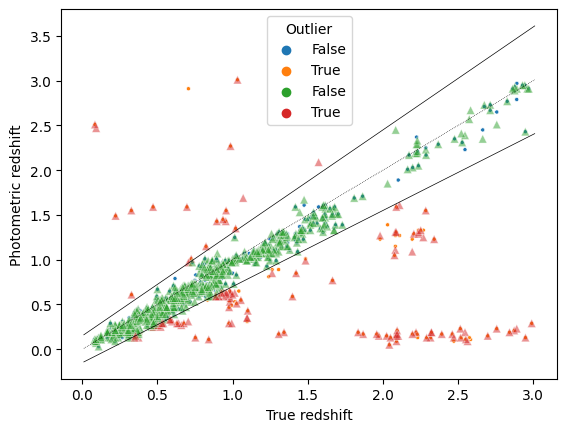

In [12]:
f,a=plt.subplots(1,1)
sns.scatterplot(data=df_ref_more, x='True redshift', y='Photometric redshift', hue='Outlier', marker='.', ax=a)
sns.scatterplot(data=df_test_more, x='True redshift', y='Photometric redshift', hue='Outlier', marker='^', alpha=0.5,\
                palette={True:'tab:red', False:'tab:green'}, ax=a)
a.plot(z_grid_ref, z_grid_ref, c='k', ls=':', lw=0.5)
a.plot(z_grid_ref, 0.15+1.15*z_grid_ref, c='k', lw=0.5)
a.plot(z_grid_ref, -0.15+0.85*z_grid_ref, c='k', lw=0.5)

In [13]:
with open(f"{ref_inputs['run name']}_posteriors_dict.pkl", 'rb') as handle:
    posteriors_dict_ref=pickle.load(handle)
with open(f"{test_inputs['run name']}_posteriors_dict.pkl", 'rb') as handle:
    posteriors_dict_test=pickle.load(handle)

In [14]:
_sel = (np.abs(df_test_more['Bias']) < np.abs(df_ref_more['Bias']))
sel_ref_df = df_ref_more[_sel]
sel_test_df = df_test_more[_sel]
sel_test_df

Id  Photometric redshift  True redshift   Template SED  \
9     1756.0                  0.69         0.7450   CWW_Scd-id45   
19    9779.0                  1.01         1.0412   CWW_Im-id113   
50   13017.0                  0.67         0.7389   CWW_Im-id113   
68   16724.0                  1.31         2.0829   CWW_Scd-id45   
77     366.0                  0.57         0.6232   CWW_Scd-id45   
..       ...                   ...            ...            ...   
959   9944.0                  2.33         2.2290   CWW_Im-id546   
962  11808.0                  0.33         0.3117    CWW_Im-id87   
973   5054.0                  0.69         0.6167  CWW_Scd-id354   
981    234.0                  0.21         0.2190   CWW_Scd-id45   
986   6270.0                  0.35         0.3880   CWW_Scd-id45   

    Extinction law  E(B-V)       Chi2 Highest evidence SED  \
9         Calzetti    0.20  35.777260         CWW_Scd-id45   
19        Calzetti    0.20  28.084959         CWW_Im-id113   
50        Calzetti    0.00  27.766617         CWW_Im-id113   
68          Prevot    0.20  33.321407         CWW_Scd-id45   
77        Calzetti    0.30  19.469788         CWW_Scd-id45   
..             ...     ...        ...                  ...   
959         Prevot    0.05  25.973288         CWW_Im-id699   
962         Prevot    0.05  27.414179          CWW_Im-id87   
973         Prevot    0.20  20.791035        CWW_Scd-id354   
981       Calzetti    0.25   9.313285         CWW_Scd-id45   
986       Calzetti    0.20  24.909718         CWW_Scd-id45   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
9                    Calzetti                     0.20  ...        20.737572   
19                   Calzetti                     0.20  ...        23.980263   
50                     Prevot                     0.00  ...        21.825554   
68                     Prevot                     0.20  ...        24.244049   
77                   Calzetti                     0.30  ...        21.341721   
..                        ...                      ...  ...              ...   
959                  Calzetti                     0.20  ...        24.379059   
962                    Prevot                     0.05  ...        24.509888   
973                    Prevot                     0.20  ...        21.931969   
981                  Calzetti                     0.25  ...        20.629814   
986                  Calzetti                     0.20  ...        21.648125   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
9               0.004075        20.384949             0.004037   
19              0.015741        23.546104             0.015499   
50              0.006082        21.655983             0.006690   
68              0.026557        23.502815             0.021867   
77              0.004596        20.922623             0.004419   
..                   ...              ...                  ...   
959             0.020710        24.362709             0.027511   
962             0.027281        24.259003             0.031783   
973             0.006248        21.581474             0.006251   
981             0.004190        20.360825             0.004336   
986             0.005100        21.314331             0.005127   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)    Bias  Outlier       U-B       R-I  
9         20.139656            0.004205 -0.0550    False  0.754272  0.967415  
19        23.283485            0.019126 -0.0312    False  0.327072  0.645691  
50        21.679893            0.008621 -0.0689    False  0.170288  0.441353  
68        22.938934            0.023214 -0.7729     True  0.420341  0.578423  
77        20.688644            0.004770 -0.0532    False  1.129486  0.875992  
..              ...                 ...     ...      ...       ...       ...  
959       24.406013            0.048626  0.1010    False  0.575539  0.043915  
962       24.335014            0.058215  0.0183    False  0.35

In [15]:
sel_ref_df

Id  Photometric redshift  True redshift      Template SED  \
9     1756.0                  0.65         0.7450     CWW_Scd-id354   
19    9779.0                  0.65         1.0412      CWW_Im-id344   
50   13017.0                  0.59         0.7389  AVG_CLUST_CWW_Im   
68   16724.0                  1.27         2.0829     CWW_Scd-id354   
77     366.0                  0.43         0.6232     CWW_Scd-id532   
..       ...                   ...            ...               ...   
959   9944.0                  0.17         2.2290      CWW_Im-id699   
962  11808.0                  0.35         0.3117      CWW_Im-id546   
973   5054.0                  0.79         0.6167       CWW_Im-id87   
981    234.0                  0.25         0.2190     CWW_Scd-id639   
986   6270.0                  0.17         0.3880     CWW_Scd-id268   

    Extinction law  E(B-V)       Chi2 Highest evidence SED  \
9           Prevot    0.30  36.921326        CWW_Scd-id354   
19          Prevot    0.30  29.558228         CWW_Im-id344   
50          Prevot    0.10  30.840328     AVG_CLUST_CWW_Im   
68          Prevot    0.35  33.808792        CWW_Scd-id532   
77          Prevot    0.50  15.016966        CWW_Scd-id532   
..             ...     ...        ...                  ...   
959       Calzetti    0.20  28.684690         CWW_Im-id699   
962       Calzetti    0.20  30.522713          CWW_Im-id87   
973       Calzetti    0.35  20.802629          CWW_Im-id87   
981       Calzetti    0.35   6.696486        CWW_Scd-id639   
986         Prevot    0.40  25.446869        CWW_Scd-id268   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
9                      Prevot                     0.30  ...        20.737572   
19                     Prevot                     0.30  ...        23.980263   
50                     Prevot                     0.10  ...        21.825554   
68                     Prevot                     0.40  ...        24.244049   
77                     Prevot                     0.50  ...        21.341721   
..                        ...                      ...  ...              ...   
959                  Calzetti                     0.20  ...        24.379059   
962                    Prevot                     0.05  ...        24.509888   
973                  Calzetti                     0.35  ...        21.931969   
981                  Calzetti                     0.35  ...        20.629814   
986                    Prevot                     0.40  ...        21.648125   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
9               0.004075        20.384949             0.004037   
19              0.015741        23.546104             0.015499   
50              0.006082        21.655983             0.006690   
68              0.026557        23.502815             0.021867   
77              0.004596        20.922623             0.004419   
..                   ...              ...                  ...   
959             0.020710        24.362709             0.027511   
962             0.027281        24.259003             0.031783   
973             0.006248        21.581474             0.006251   
981             0.004190        20.360825             0.004336   
986             0.005100        21.314331             0.005127   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)    Bias  Outlier       U-B       R-I  
9         20.139656            0.004205 -0.0950    False  0.754272  0.967415  
19        23.283485            0.019126 -0.3912     True  0.327072  0.645691  
50        21.679893            0.008621 -0.1489    False  0.170288  0.441353  
68        22.938934            0.023214 -0.8129     True  0.420341  0.578423  
77        20.688644            0.004770 -0.1932    False  1.129486  0.875992  
..              ...                 ...     ...      ...       ...       ...  
959       24.406013            0.048626 -2.0590     True  0.575539  0.043915  
962       24.335014       

In [16]:
good_case, bad_case = 959, 55

In [17]:
good_test_df = pd.DataFrame(posteriors_dict_test[good_case]['5 most likely models'])
good_ref_df = pd.DataFrame(posteriors_dict_ref[good_case]['5 most likely models'])

In [18]:
good_test_df

Template SED  Dust law E(B-V)  zp (mode) average(z)      sigma(z)  \
0      CWW_Im-id699  Calzetti    0.2       0.17  1.1769497     1.3032801   
1      CWW_Im-id546    Prevot   0.05       2.33   2.282685     0.1676091   
2  AVG_CLUST_CWW_Im    Prevot   0.05  2.4099998  2.4327192  0.0058379024   
3      CWW_Im-id537    Prevot   0.05       2.47  2.4324818   0.045742437   
4      CWW_Im-id107    Prevot   0.05       2.27  2.2480843   0.044239633   

  median(z)   Odd ratio        Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      0.25   1.0798563      -2.059         25.02069       25.036522   
1      2.37  0.99999994  0.10099983        25.024559       25.080559   
2      2.45   0.9331634  0.18099976        25.017395       25.048203   
3      2.49   0.8700339  0.24099994        25.010681       25.086647   
4      2.29  0.59243196  0.04099989        25.025917       25.171532   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   24.556557   24.408699    24.39051   24.367928   24.368889  
1   24.529137   24.398956    24.38736   24.390068   24.381485  
2   24.550575    24.40599   24.381866    24.39434   24.376595  
3   24.532333   24.398705   24.397812   24.401604   24.369125  
4   24.530273   24.408768   24.369102   24.363548   24.367676

In [19]:
good_ref_df

Template SED  Dust law E(B-V)  zp (mode) average(z)      sigma(z)  \
0      CWW_Im-id699  Calzetti    0.2       0.17  1.1769497     1.3032801   
1      CWW_Im-id546    Prevot   0.05       2.33  2.2826848     0.1676091   
2      CWW_Im-id107  Calzetti    0.1       2.33  2.3156295   0.075506136   
3  AVG_CLUST_CWW_Im    Prevot   0.05  2.4099998  2.4327192  0.0058379024   
4      CWW_Im-id546  Calzetti    0.1       2.45  2.2982726    0.32497954   

  median(z)   Odd ratio        Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      0.25         1.0      -2.059         25.02069       25.036522   
1      2.37  0.63864726  0.10099983        25.024559       25.080559   
2      2.37   0.5975573  0.10099983         25.03334       25.084587   
3      2.45   0.5959622  0.18099976        25.017395       25.048203   
4      2.47  0.59424585  0.22099996        25.015556       25.092255   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   24.556557   24.408699    24.39051   24.367928   24.368889  
1   24.529137   24.398956    24.38736   24.390068   24.381485  
2   24.517586   24.417076   24.381157   24.372643    24.36425  
3   24.550575    24.40599   24.381866    24.39434   24.376595  
4   24.518227    24.40767   24.386978   24.405243   24.389442

In [20]:
bad_test_df = pd.DataFrame(posteriors_dict_test[bad_case]['5 most likely models'])
bad_ref_df = pd.DataFrame(posteriors_dict_ref[bad_case]['5 most likely models'])
bad_test_df

Template SED  Dust law E(B-V)    zp (mode) average(z)      sigma(z)  \
0  CWW_Im-id107    Prevot   0.05    2.4099998  2.4452953  0.0046927882   
1  CWW_Im-id537    Prevot   0.05  0.089999996  1.0173846      1.507766   
2  CWW_Im-id699  Calzetti   0.25    2.4299998  2.1564445     0.5764225   
3  CWW_Im-id107  Calzetti    0.1         2.57  2.5469007  0.0031487243   
4  CWW_Im-id537    Prevot    0.0         0.13  0.1393169   0.007497526   

  median(z)  Odd ratio          Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      2.47  1.3953192   -0.15300012        25.061356       25.126114   
1      0.17        1.0        -2.473        25.114166       25.186836   
2      2.45  0.8695731   -0.13300014        25.085983       25.185173   
3      2.59  0.6626445  0.0069999695         25.08377       25.293495   
4      0.17  0.6315439        -2.433        25.056648       25.088364   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0     24.4766   24.305199    24.25232   24.252014   24.252563  
1    24.46473    24.32035   24.252983   24.189034   24.151527  
2   24.481506   24.298164    24.24279   24.230995   24.212868  
3   24.444962   24.301468   24.236229   24.249474   24.225777  
4    24.45794   24.326836   24.283287   24.228401    24.20462

In [21]:
bad_ref_df

Template SED  Dust law E(B-V)   zp (mode)  average(z)       sigma(z)  \
0  CWW_Im-id699    Prevot   0.35  0.10999999  0.11533946  0.00075532566   
1  CWW_Im-id699  Calzetti   0.25   2.4299998   2.1564445      0.5764227   
2  CWW_Im-id107    Prevot   0.05   2.4099998   2.4452953   0.0046927864   
3  CWW_Im-id546  Calzetti   0.15   2.4099998   2.4253426    0.006773587   
4  CWW_Im-id265  Calzetti   0.15        2.57   2.5534585    0.011185023   

  median(z)   Odd ratio          Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      0.15         1.0        -2.453        25.109428        25.16018   
1      2.45  0.78811336   -0.13300014        25.085983       25.185173   
2      2.47   0.6831955   -0.15300012        25.061356       25.126114   
3      2.45  0.59562606   -0.15300012         25.08371        25.15863   
4      2.59  0.55156356  0.0069999695        25.075455       25.253944   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   24.463196   24.248802   24.268913   24.268494   24.199997  
1   24.481506   24.298164    24.24279   24.230995   24.212868  
2     24.4766   24.305199    24.25232   24.252014   24.252563  
3   24.484673   24.311882   24.246925   24.222527   24.184319  
4   24.459572   24.300041   24.240662   24.249832   24.217476

In [22]:
df_test_more.columns

Index(['Id', 'Photometric redshift', 'True redshift', 'Template SED',
       'Extinction law', 'E(B-V)', 'Chi2', 'Highest evidence SED',
       'Highest evidence dust law', 'Highest evidence E(B-V)',
       'Highest evidence odd ratio', 'Highest evidence z_phot (mode)',
       'Highest evidence z_phot (mean)', 'Highest evidence sigma(z)',
       'Best SED at z_spec', 'Best dust law at z_spec', 'E(B-V) at z_spec',
       'Mode of best model at z_spec', 'Mean of best model at z_spec',
       'Odd ratio of best model at z_spec', 'MagAB(cosmos_u_cfht)',
       'err_MagAB(cosmos_u_cfht)', 'MagAB(cosmos_u_new)',
       'err_MagAB(cosmos_u_new)', 'MagAB(hsc_gHSC)', 'err_MagAB(hsc_gHSC)',
       'MagAB(hsc_rHSC)', 'err_MagAB(hsc_rHSC)', 'MagAB(hsc_iHSC)',
       'err_MagAB(hsc_iHSC)', 'MagAB(hsc_zHSC)', 'err_MagAB(hsc_zHSC)',
       'MagAB(hsc_yHSC)', 'err_MagAB(hsc_yHSC)', 'Bias', 'Outlier', 'U-B',
       'R-I'],
      dtype='object')

<AxesSubplot:xlabel='True redshift', ylabel='Highest evidence odd ratio'>

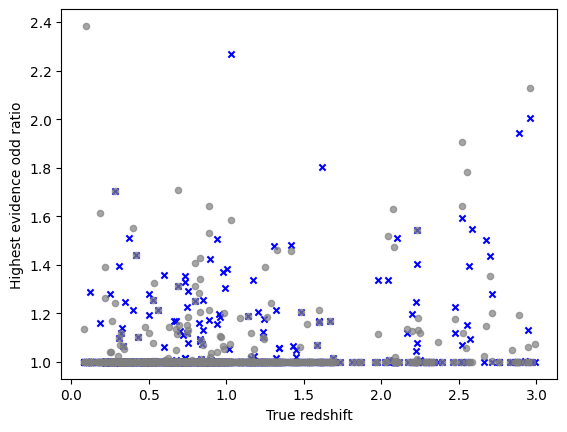

In [23]:
f,a=plt.subplots(1,1)
df_test_more.plot.scatter('True redshift', 'Highest evidence odd ratio', c='blue', marker='x', ax=a)
df_ref_more.plot.scatter('True redshift', 'Highest evidence odd ratio', c='grey', alpha=0.7, ax=a)

In [24]:
def zp_zs_plot(photo_z_df, x_series, y_series, outlier_lim_pct=15, hue=None):
    f,a=plt.subplots(1,1)
    if hue is None:
        df_to_plot = photo_z_df[[photo_z_df.columns[0], x_series, y_series]].copy()
        hue='outlier'
    else:
        df_to_plot = photo_z_df[[photo_z_df.columns[0], x_series, y_series, hue]].copy()
    df_to_plot['bias'] = df_to_plot[y_series]-df_to_plot[x_series]
    df_to_plot['scatter'] = np.abs(df_to_plot['bias']/(1.+df_to_plot[x_series]))
    df_to_plot['outlier'] = (df_to_plot['scatter'] > outlier_lim_pct/100)
    outl_rate = 100.0*len(df_to_plot[df_to_plot['outlier']])/len(df_to_plot)
    
    med = np.median(df_to_plot[x_series])
    resids = np.abs(df_to_plot[y_series] - med)
    
    NMAD = 1.4826 * np.median(df_to_plot['scatter'])

    sns.scatterplot(data=df_to_plot, x=x_series, y=y_series, hue=hue, marker='.', ax=a)
    a.plot(df_to_plot[x_series].values, df_to_plot[x_series].values, c='k', ls=':', lw=0.5)
    a.plot(df_to_plot[x_series].values, outlier_lim_pct/100+(1.+outlier_lim_pct/100)*df_to_plot[x_series].values, c='k', lw=0.5)
    a.plot(df_to_plot[x_series].values, -outlier_lim_pct/100+(1.-outlier_lim_pct/100)*df_to_plot[x_series].values, c='k', lw=0.5)
    a.set_title("$z_{phot}$ vs. $z_{spec}$ : "+f"{outl_rate:.3f}% outliers @{outlier_lim_pct}% ; NMAD={NMAD:.4f}")
    
def which_is_best(photo_z_df):
    poss_src = np.array(['Photometric redshift', 'Highest evidence z_phot (mode)', 'Highest evidence z_phot (mean)'])
    bias_mode = np.abs(photo_z_df['Bias'].values)
    bias_ev_mode = np.abs(photo_z_df['Highest evidence z_phot (mode)'].values - photo_z_df['True redshift'].values)
    bias_ev_mean = np.abs(photo_z_df['Highest evidence z_phot (mean)'].values - photo_z_df['True redshift'].values)
    
    best_pestim = []
    for m, ev_mo, ev_me in zip(bias_mode, bias_ev_mode, bias_ev_mean):
        order = np.argsort([m, ev_mo, ev_me])
        sorted_es = poss_src[order]
        best_pestim.append(sorted_es[0])
        '''
        if ev_me<ev_mo and ev_me<m :
            best_pestim.append('Highest evidence z_phot (mean)')
        elif ev_mo<m and ev_mo<ev_me :
            best_pestim.append('Highest evidence z_phot (mode)')
        else :
            assert (m<=ev_mo and m<=ev_me), "Error in logic."
            best_pestim.append('Photometric redshift')
        '''
                
    best_zp = np.array([ photo_z_df.loc[photo_z_df.index[n], esti] for n,esti in enumerate(best_pestim) ])
    
    photo_z_df['Best estimator']=np.array(best_pestim)
    photo_z_df['Best point estimate']=best_zp
    zp_zs_plot(photo_z_df, 'True redshift', 'Best point estimate', hue='Best estimator')
    

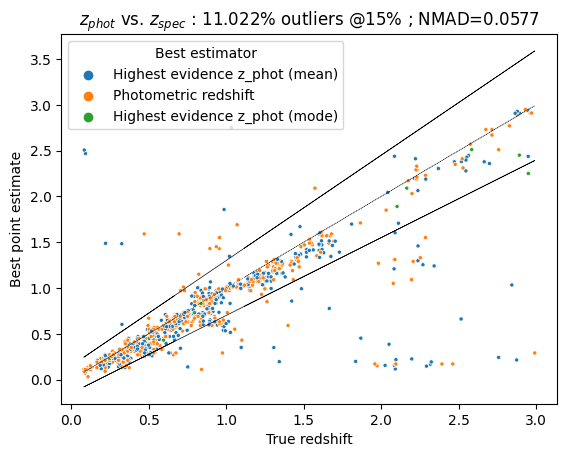

In [25]:
which_is_best(df_test_more)

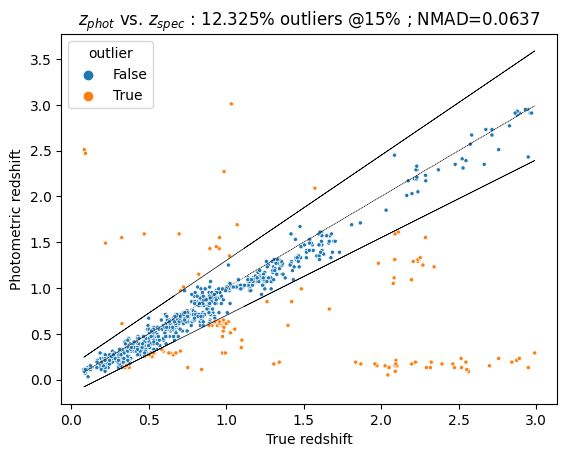

In [26]:
zp_zs_plot(df_test_more, 'True redshift', 'Photometric redshift')

In [27]:
bad_test_df = pd.DataFrame(posteriors_dict_test[bad_case]['5 best models at z_spec'])
bad_ref_df = pd.DataFrame(posteriors_dict_ref[bad_case]['5 best models at z_spec'])
bad_test_df

Template SED  Dust law E(B-V)  zp (mode) average(z)      sigma(z)  \
0  CWW_Im-id107  Calzetti    0.1       2.57  2.5469007  0.0031487243   
1  CWW_Im-id265  Calzetti   0.15       2.57  2.5534587    0.01118502   
2  CWW_Im-id546    Prevot   0.05       2.59   2.580206  0.0037254163   
3  CWW_Im-id537  Calzetti   0.15       2.55   2.529912  0.0047060614   
4  CWW_Im-id107    Prevot   0.05  2.4099998  2.4452953  0.0046927882   

  median(z)   Odd ratio          Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      2.59   0.6626445  0.0069999695        25.077187       25.281593   
1      2.59  0.56992394  0.0069999695            25.07       25.243912   
2      2.61    0.608109    0.02699995        25.043938        25.19178   
3      2.57  0.55720127  -0.013000011        25.083214          25.249   
4      2.47   1.3953192   -0.15300012         25.13279       25.330482   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   24.445717   24.303581   24.238739    24.25193   24.228455  
1    24.45974   24.301964   24.243195   24.251877   24.219643  
2     24.4767   24.298904    24.24398   24.278328   24.258675  
3    24.47329   24.299202   24.244652   24.236328   24.167099  
4   24.484024   24.284111   24.209877   24.218086    24.20134

Text(0, 0.5, '$p(z|model)$')

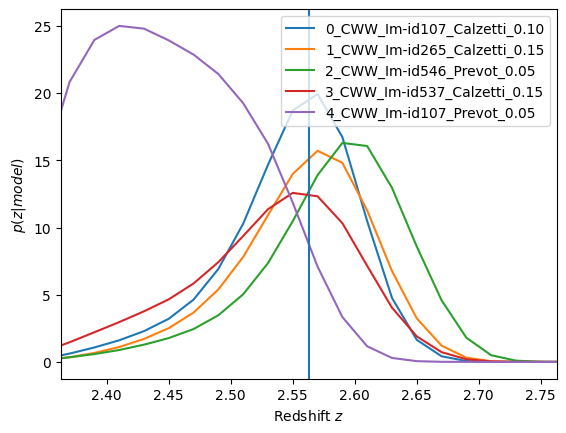

In [28]:
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
posterior = posteriors_dict_test[bad_case]['Full posterior']
for item in bad_test_df.index :
    mod_num=np.argwhere(temp_names == bad_test_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==bad_test_df.loc[item, 'Dust law'] and d.EBV==bad_test_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-bad_test_df.loc[item, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    #print(temp_names[mod_num])
    #print(dust_arr_test[dust_num])
    #print(z_grid_test[z_num])
    plt.plot(z_grid_test, posterior[mod_num, dust_num, :],\
             label=f"{item}_{bad_test_df.loc[item, 'Template SED']}_{bad_test_df.loc[item, 'Dust law']}_{bad_test_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_test_more.loc[bad_case, "True redshift"])
plt.xlim(df_test_more.loc[bad_case, "True redshift"]-0.2, df_test_more.loc[bad_case, "True redshift"]+0.2)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z|model)$")

In [29]:
good_test_df = pd.DataFrame(posteriors_dict_test[good_case]['5 best models at z_spec'])
good_ref_df = pd.DataFrame(posteriors_dict_ref[good_case]['5 best models at z_spec'])
good_test_df

Template SED  Dust law E(B-V) zp (mode) average(z)     sigma(z) median(z)  \
0  CWW_Im-id107    Prevot   0.05      2.27  2.2480843  0.044239633      2.29   
1  CWW_Im-id699    Prevot    0.1      2.27  2.2781193  0.002960786      2.31   
2  CWW_Im-id699  Calzetti   0.25      2.27  1.8765185   0.68620133      2.27   
3  CWW_Im-id546  Calzetti   0.15      2.25  2.2439232  0.002615909      2.27   
4  CWW_Im-id546    Prevot   0.05      2.33   2.282685    0.1676091      2.37   

    Odd ratio         Bias M(cosmos_u_cfht) M(cosmos_u_new) M(hsc_gHSC)  \
0  0.59243196   0.04099989        24.981033       25.183846   24.535645   
1   0.3525411   0.04099989        24.982475       25.129059   24.542686   
2  0.28014117   0.04099989         24.98201       25.160255   24.563332   
3  0.14473306  0.020999908        24.995651        25.18937   24.560295   
4  0.99999994   0.10099983        24.937798       25.100952   24.538078   

  M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   24.425468    24.39087   24.385109    24.38926  
1   24.398415    24.39051   24.424309   24.448677  
2   24.428062   24.387512   24.370956   24.347725  
3   24.428703    24.39064    24.34542   24.294373  
4   24.435524    24.43895   24.436852   24.421196

Text(0, 0.5, '$p(z|model)$')

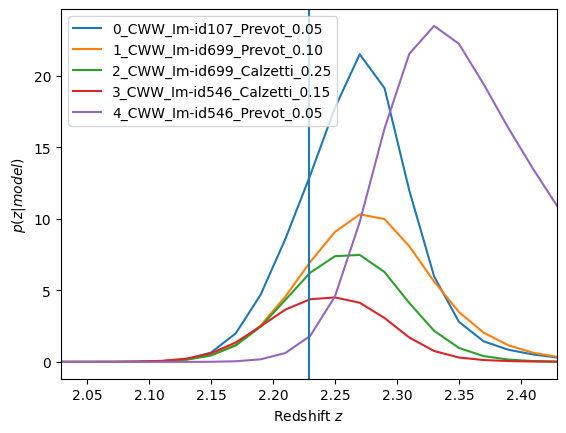

In [30]:
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
posterior = posteriors_dict_test[good_case]['Full posterior']
for item in good_test_df.index :
    mod_num=np.argwhere(temp_names == good_test_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[item, 'Dust law'] and d.EBV==good_test_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[item, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    plt.plot(z_grid_test, posterior[mod_num, dust_num, :],\
             label=f"{item}_{good_test_df.loc[item, 'Template SED']}_{good_test_df.loc[item, 'Dust law']}_{good_test_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_test_more.loc[good_case, "True redshift"])
plt.xlim(df_test_more.loc[good_case, "True redshift"]-0.2, df_test_more.loc[good_case, "True redshift"]+0.2)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z|model)$")

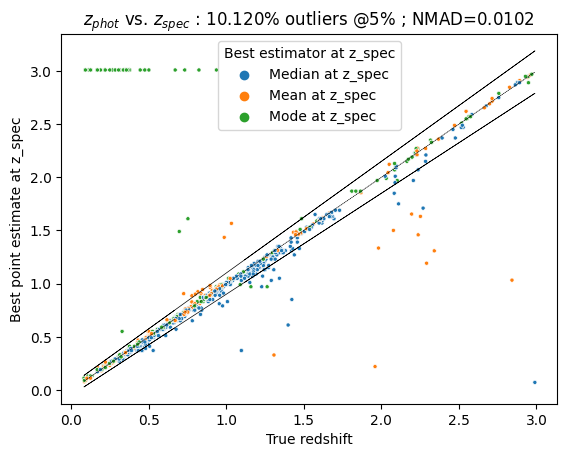

In [31]:
modes_zs = []
means_zs = []
meds_zs = []
best_estim_at_zs = []
best_zp_at_zs = []

for loc, _case in enumerate(df_test_more.index):
    posterior = posteriors_dict_test[_case]['Full posterior']
    good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])
    
    mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    mode_at_zs = good_test_df.loc[0, 'zp (mode)']
    mean_at_zs = good_test_df.loc[0, 'average(z)']
    med_at_zs = good_test_df.loc[0, 'median(z)']
    tru_z = df_test_more.loc[_case, "True redshift"]
    
    poss_zp = np.array([mode_at_zs, mean_at_zs, med_at_zs])
    
    bias_mode = np.abs(mode_at_zs-tru_z)
    bias_mean = np.abs(mean_at_zs-tru_z)
    try :
        bias_med = np.abs(med_at_zs-tru_z)
    except TypeError:
        bias_med = 99
    
    poss_src = np.array(['Mode at z_spec', 'Mean at z_spec', 'Median at z_spec'])
    
    best_pestim = []

    order = np.argsort([bias_mode, bias_mean, bias_med])
    sorted_es = poss_src[order]
    sorted_zp = poss_zp[order]
    best_estim_at_zs.append(sorted_es[0])
    best_zp_at_zs.append(sorted_zp[0])
    
df_test_more['Best estimator at z_spec']=np.array(best_estim_at_zs)
df_test_more['Best point estimate at z_spec']=np.array(best_zp_at_zs)
zp_zs_plot(df_test_more, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

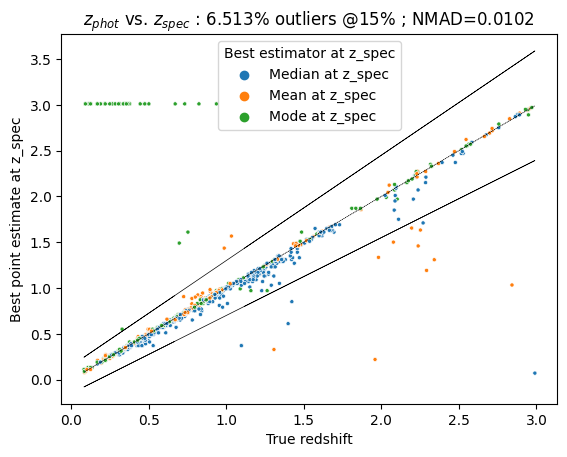

In [32]:
zp_zs_plot(df_test_more, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=15, hue='Best estimator at z_spec')

## Z-spec models study

<AxesSubplot:xlabel='Odd ratio of best model at z_spec', ylabel='Count'>

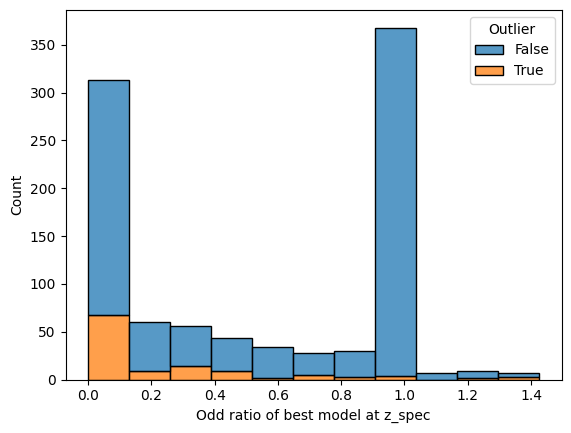

In [33]:
sns.histplot(data=df_test_more, x='Odd ratio of best model at z_spec', hue='Outlier', stat='count', multiple='stack')

In [34]:
len(np.unique(df_test_more['Best SED at z_spec'].values))

27

In [35]:
len(np.unique(df_test_more['Template SED'].values))

28

Not many templates are rejected during the run. Too bad !

In [36]:
np.nanmean(df_test_more['Odd ratio of best model at z_spec'].values)

0.5402822294445574

In [37]:
sub_df = df_test_more[np.isfinite(df_test_more['Odd ratio of best model at z_spec'].values)]
len(sub_df)

955

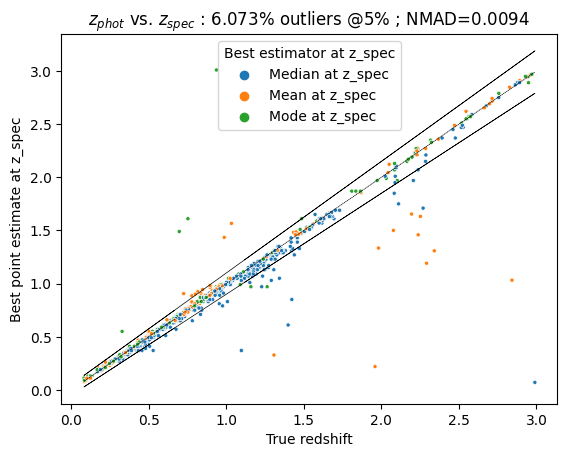

In [38]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

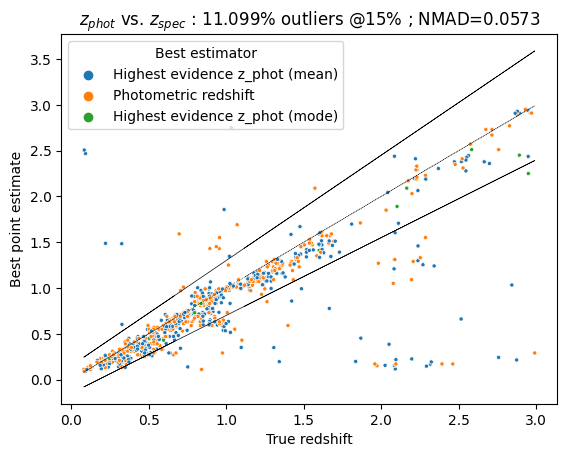

In [39]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate', hue='Best estimator')

In [40]:
np.mean(sub_df['Odd ratio of best model at z_spec'].values)

0.5402822294445574

In [41]:
np.median(sub_df['Odd ratio of best model at z_spec'].values)

0.5299990773200989

<AxesSubplot:xlabel='Odd ratio of best model at z_spec', ylabel='Count'>

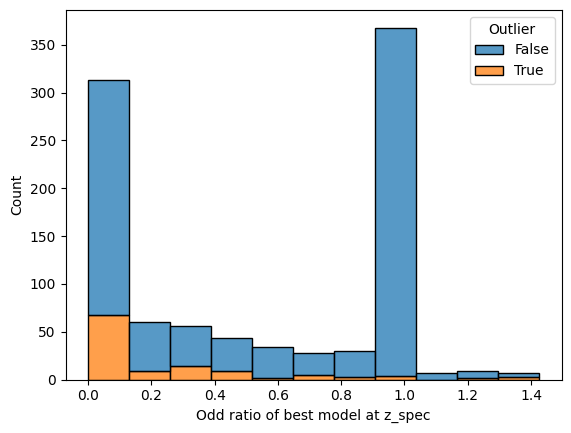

In [42]:
sns.histplot(data=sub_df, x='Odd ratio of best model at z_spec', hue='Outlier', stat='count', multiple='stack')

In [43]:
sub_df = df_test_more[[not b for b in np.isfinite(df_test_more['Odd ratio of best model at z_spec'].values)]]
len(sub_df)

43

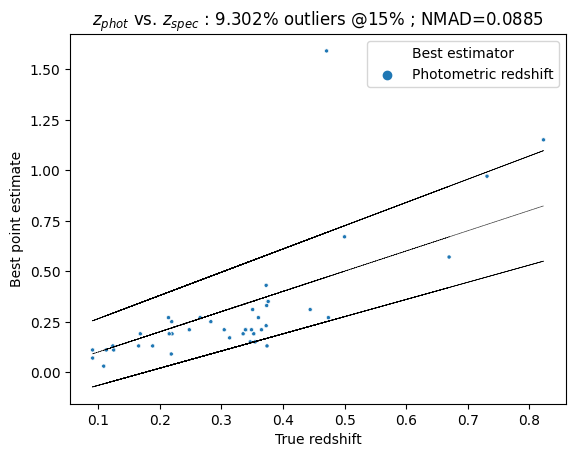

In [44]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate', hue='Best estimator')

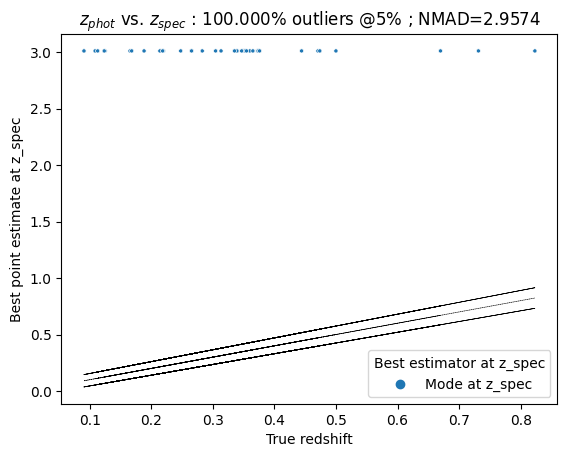

In [45]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

In [46]:
sub_df[[c for c in sub_df.columns if 'evidence' in c]]

Highest evidence SED Highest evidence dust law  Highest evidence E(B-V)  \
34         CWW_Scd-id585                    Prevot                      0.5   
48         CWW_Scd-id585                    Prevot                      0.5   
113        CWW_Scd-id585                    Prevot                      0.5   
115        CWW_Scd-id585                    Prevot                      0.5   
154        CWW_Scd-id585                    Prevot                      0.5   
157        CWW_Scd-id585                    Prevot                      0.5   
174        CWW_Scd-id585                    Prevot                      0.5   
188        CWW_Scd-id585                    Prevot                      0.5   
195        CWW_Scd-id585                    Prevot                      0.5   
204        CWW_Scd-id585                    Prevot                      0.5   
253        CWW_Scd-id585                    Prevot                      0.5   
276        CWW_Scd-id585                    Prevot                      0.5   
281        CWW_Scd-id585                    Prevot                      0.5   
296        CWW_Scd-id585                    Prevot                      0.5   
330        CWW_Scd-id585                    Prevot                      0.5   
331        CWW_Scd-id585                    Prevot                      0.5   
338        CWW_Scd-id585                    Prevot                      0.5   
370        CWW_Scd-id585                    Prevot                      0.5   
375        CWW_Scd-id585                    Prevot                      0.5   
385        CWW_Scd-id585                    Prevot                      0.5   
413        CWW_Scd-id585                    Prevot                      0.5   
415        CWW_Scd-id585                    Prevot                      0.5   
423        CWW_Scd-id585                    Prevot                      0.5   
442        CWW_Scd-id585                    Prevot                      0.5   
511        CWW_Scd-id585                    Prevot                      0.5   
541        CWW_Scd-id585                    Prevot                      0.5   
667        CWW_Scd-id585                    Prevot                      0.5   
713        CWW_Scd-id585                    Prevot                      0.5   
736        CWW_Scd-id585                    Prevot                      0.5   
738        CWW_Scd-id585                    Prevot                      0.5   
766        CWW_Scd-id585                    Prevot                      0.5   
771        CWW_Scd-id585                    Prevot                      0.5   
801        CWW_Scd-id585                    Prevot                      0.5   
829        CWW_Scd-id585                    Prevot                      0.5   
831        CWW_Scd-id585                    Prevot                      0.5   
868        CWW_Scd-id585                    Prevot                      0.5   
878        CWW_Scd-id585                    Prevot                      0.5   
892        CWW_Scd-id585                    Prevot                      0.5   
927        CWW_Scd-id585                    Prevot                      0.5   
932        CWW_Scd-id585                    Prevot                      0.5   
940        CWW_Scd-id585                    Prevot                      0.5   
974        CWW_Scd-id585                    Prevot                      0.5   
976        CWW_Scd-id585                    Prevot                      0.5   

     Highest evidence odd ratio  Highest evidence z_phot (mode)  \
34                          NaN                            3.01   
48                          NaN                            3.01   
113                         NaN                            3.01   
115                         NaN                            3.01   
154                         NaN                            3.01   
157                         NaN                            3.01   
174                         NaN                           

In [47]:
id_zarbi=34
posterior = posteriors_dict_test[id_zarbi]['Full posterior']
zarbi_df_zs = pd.DataFrame(posteriors_dict_test[id_zarbi]['5 best models at z_spec'])
zarbi_df_ev = pd.DataFrame(posteriors_dict_test[id_zarbi]['5 most likely models'])

In [48]:
zarbi_df_zs

Template SED Dust law E(B-V) zp (mode) average(z) sigma(z) median(z)  \
0  CWW_Scd-id585   Prevot    0.5      3.01        nan      nan      None   
1  CWW_Scd-id585   Prevot    0.4      3.01        nan      nan      None   
2  CWW_Scd-id585   Prevot   0.35      3.01        nan      nan      None   
3  CWW_Scd-id585   Prevot    0.3      3.01        nan      nan      None   
4  CWW_Scd-id585   Prevot   0.25      3.01        nan      nan      None   

  Odd ratio    Bias M(cosmos_u_cfht) M(cosmos_u_new) M(hsc_gHSC) M(hsc_rHSC)  \
0       nan  2.9192         21.12458       21.432816   19.427605   18.766327   
1       nan  2.9192        20.983788       21.269379   19.394363   18.819237   
2       nan  2.9192         20.92714        21.20169   19.391403   18.859749   
3       nan  2.9192        20.880028       21.143707   19.397903    18.90998   
4       nan  2.9192        20.842407        21.09539   19.413834   18.969894   

  M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   18.465553   18.215141    18.04264  
1   18.558296   18.338448    18.18885  
2   18.618752   18.414207   18.276062  
3   18.688957   18.499748   18.373032  
4   18.768867   18.595009   18.479721

In [49]:
zarbi_df_ev

Template SED Dust law E(B-V) zp (mode) average(z) sigma(z) median(z)  \
0  CWW_Scd-id585   Prevot    0.5      3.01        nan      nan      None   
1  CWW_Scd-id585   Prevot    0.4      3.01        nan      nan      None   
2  CWW_Scd-id585   Prevot   0.35      3.01        nan      nan      None   
3  CWW_Scd-id585   Prevot    0.3      3.01        nan      nan      None   
4  CWW_Scd-id585   Prevot   0.25      3.01        nan      nan      None   

  Odd ratio    Bias M(cosmos_u_cfht) M(cosmos_u_new) M(hsc_gHSC) M(hsc_rHSC)  \
0       nan  2.9192        31.269493       33.291855   25.384804   20.965752   
1       nan  2.9192        30.199806       31.829529   24.607277   20.571686   
2       nan  2.9192        29.650772       31.105293   24.224945   20.379807   
3       nan  2.9192        29.092117       30.386353   23.847496   20.191917   
4       nan  2.9192        28.524185        29.67318    23.47538    20.00843   

  M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0    18.84655   18.014206    17.61274  
1   18.666473     17.9692     17.6708  
2   18.583351   17.954025   17.707344  
3   18.505478   17.944397   17.749573  
4   18.433372   17.940842    17.79802

In [50]:
sub_df = df_test_more[np.isfinite(df_test_more['Odd ratio of best model at z_spec'].values)]

In [51]:
sub_df[[c for c in sub_df.columns if 'evidence' in c]]

Highest evidence SED Highest evidence dust law  Highest evidence E(B-V)  \
0           CWW_Im-id546                    Prevot                     0.25   
1          CWW_Scd-id354                  Calzetti                     0.15   
2           CWW_Im-id537                    Prevot                     0.20   
3           CWW_Im-id113                    Prevot                     0.20   
4          CWW_Scd-id532                    Prevot                     0.20   
..                   ...                       ...                      ...   
995         CWW_Im-id265                    Prevot                     0.10   
996          CWW_E-id235                  Calzetti                     0.10   
997        CWW_Scd-id268                    Prevot                     0.05   
998         CWW_Im-id113                    Prevot                     0.15   
999         CWW_Im-id113                    Prevot                     0.05   

     Highest evidence odd ratio  Highest evidence z_phot (mode)  \
0                           1.0                            0.61   
1                           1.0                            0.27   
2                           1.0                            0.21   
3                           1.0                            0.65   
4                           1.0                            1.35   
..                          ...                             ...   
995                         1.0                            2.35   
996                         1.0                            0.73   
997                         1.0                            0.63   
998                         1.0                            0.87   
999                         1.0                            1.03   

     Highest evidence z_phot (mean)  Highest evidence sigma(z)  
0                          0.613186                   0.000299  
1                          0.269855                   0.000003  
2                          0.211476                   0.000032  
3                          0.644358                   0.000396  
4                          1.346265                   0.000578  
..                              ...                        ...  
995                        2.377516                   0.003181  
996                        0.731324                   0.000025  
997                        0.630095                   0.000112  
998                        0.859542                   0.000266  
999                        1.023042                   0.000239  

[955 rows x 7 columns]

<AxesSubplot:xlabel='Highest evidence odd ratio', ylabel='Count'>

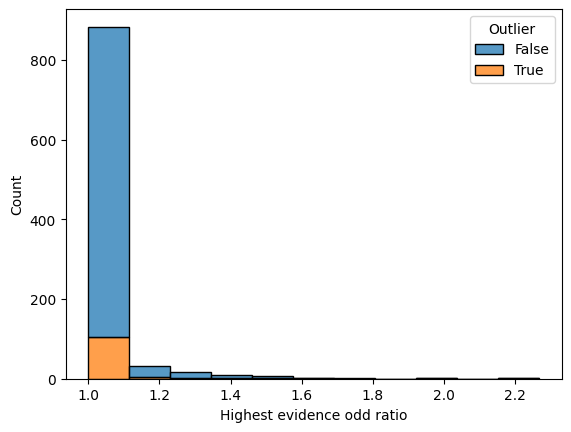

In [52]:
sns.histplot(data=sub_df, x='Highest evidence odd ratio', hue='Outlier', stat='count', multiple='stack')

In [53]:
id_test_pointEst=15
posterior = posteriors_dict_test[id_test_pointEst]['Full posterior']
pointEst_df_ev = pd.DataFrame(posteriors_dict_test[id_test_pointEst]['5 most likely models'])
pointEst_df_ev

Template SED  Dust law E(B-V)  zp (mode)  average(z)      sigma(z)  \
0    CWW_Im-id87  Calzetti   0.05  2.4299998   2.4104896  0.0040369057   
1    CWW_Im-id87    Prevot   0.05       2.23   2.2375083  0.0022599483   
2  CWW_Scd-id639    Prevot    0.0       0.19  0.30464596    0.29846308   
3  CWW_Scd-id639  Calzetti    0.0       0.19  0.30464596    0.29846308   
4   CWW_Im-id107    Prevot    0.1       2.55   2.5261943   0.006540906   

  median(z)   Odd ratio        Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      2.45   1.0449785  0.20969987        25.832176       26.011635   
1      2.27    1.034913  0.00970006          25.7313       26.194534   
2      0.23         1.0     -2.0303        25.736618        25.83657   
3      0.23         1.0     -2.0303        25.736618        25.83657   
4      2.57  0.49476022      0.3297        25.734001       25.962059   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   24.746834   24.427834   24.302162   24.224663   24.120918  
1   24.809189   24.450676   24.331703     24.1604   24.009377  
2   24.832664   24.425087   24.288857   24.207024   24.160973  
3   24.832664   24.425087   24.288857   24.207024   24.160973  
4   24.847298   24.449081   24.264473   24.198257   24.143784

In [54]:
def weighted_point_est(true_z, a,b,c):
    a1 = a*pointEst_df_ev.loc[0, 'Odd ratio']
    b1 = b*pointEst_df_ev.loc[1, 'Odd ratio']
    c1 = c*pointEst_df_ev.loc[2, 'Odd ratio']
    z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
    bias = np.abs(true_z-z_pointEst)
    return bias

In [55]:
weighted_point_est(sub_df.loc[id_test_pointEst, 'True redshift'], 1,1,1)

0.55167556

In [56]:
sub_df.loc[id_test_pointEst, 'Bias']

-2.0303000023841857

In [57]:
sub_sub_df = sub_df[sub_df['Highest evidence odd ratio'] > 1.]
sub_sub_df

Id  Photometric redshift  True redshift   Template SED  \
14    1846.0                  0.63         0.6850    CWW_E-id282   
15    6568.0                  0.19         2.2203  CWW_Scd-id639   
16    1151.0                  0.55         0.5274   CWW_Im-id537   
20    5992.0                  0.27         0.6585  CWW_Scd-id268   
24   15046.0                  0.67         0.7276   CWW_Im-id113   
..       ...                   ...            ...            ...   
959   9944.0                  2.33         2.2290   CWW_Im-id546   
969  13446.0                  0.65         0.7308   CWW_Scd-id45   
984  10879.0                  0.29         0.1868  CWW_Scd-id639   
990  11291.0                  2.95         2.9290   CWW_Im-id546   
994   3065.0                  0.23         2.8903  CWW_Scd-id585   

    Extinction law  E(B-V)       Chi2 Highest evidence SED  \
14        Calzetti    0.20   8.044220        CWW_Sbc-id451   
15        Calzetti    0.00  26.027418          CWW_Im-id87   
16        Calzetti    0.05  25.732786     AVG_CLUST_CWW_Im   
20        Calzetti    0.25  22.887430        CWW_Scd-id268   
24          Prevot    0.05  17.063402         CWW_Im-id113   
..             ...     ...        ...                  ...   
959         Prevot    0.05  25.973288         CWW_Im-id699   
969       Calzetti    0.40  28.137486        CWW_Scd-id639   
984       Calzetti    0.00  22.638868        CWW_Scd-id354   
990         Prevot    0.05  27.817621         CWW_Im-id107   
994       Calzetti    0.00  28.171988          CWW_Im-id87   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_yHSC)  \
14                   Calzetti                     0.20  ...        20.964348   
15                   Calzetti                     0.05  ...        24.110420   
16                     Prevot                     0.05  ...        24.614975   
20                   Calzetti                     0.25  ...        20.380989   
24                     Prevot                     0.05  ...        21.997017   
..                        ...                      ...  ...              ...   
959                  Calzetti                     0.20  ...        24.406013   
969                  Calzetti                     0.50  ...        21.192474   
984                    Prevot                     0.00  ...        23.573334   
990                    Prevot                     0.05  ...        24.073059   
994                    Prevot                     0.05  ...        24.181839   

     err_MagAB(hsc_yHSC)    Bias  Outlier       U-B       R-I  \
14              0.005703 -0.0550    False  1.632057  1.166130   
15              0.039643 -2.0303     True  1.248039  0.118515   
16              0.059188  0.0226    False  0.075691  0.243073   
20              0.004934 -0.3885     True       NaN  0.675446   
24              0.009882 -0.0576    False  0.225800  0.520172   
..                   ...     ...      ...       ...       ...   
959             0.048626  0.1010    False  0.575539  0.043915   
969             0.005955 -0.0808    False  1.220024  1.136635   
984             0.025228  0.1032    False  0.923431  0.239784   
990             0.039745  0.0210    False  1.496895  0.072495   
994             0.042466 -2.6603     True  1.238106  0.170616   

                     Best estimator  Best point estimate  \
14   Highest evidence z_phot (mean)             0.682500   
15   Highest evidence z_phot (mean)             2.410490   
16             Photometric redshift             0.550000   
20             Photometric redshift             0.270000   
24   Highest evidence z_phot (mean)             0.672056   
..                              ...                  ...   
959            Photometric redshift             2.330000   
969  Highest evidence z_phot (mean)             0.679092   
984  Highest evidence z_phot (mean)             0.155746   
990            Photometric redshift             2.950000   
994  Highest evidence z_phot (mode)           

In [58]:
from scipy.optimize import curve_fit

y_data = np.abs(sub_df['Best point estimate at z_spec'].values - sub_df['True redshift'].values)
x_data = np.array(sub_df.index)

def get_odd_ratios(xx, rank):
    odd_rat = []
    for x in xx :
        pointEst_df_ev = pd.DataFrame(posteriors_dict_test[x]['5 most likely models'])
        odd_rat.append(pointEst_df_ev.loc[rank, 'Odd ratio'])
    return np.array(odd_rat)

def get_avg_z(xx, rank):
    avg_z = []
    for x in xx :
        pointEst_df_ev = pd.DataFrame(posteriors_dict_test[x]['5 most likely models'])
        avg_z.append(pointEst_df_ev.loc[rank, 'average(z)'])
    return np.array(avg_z)

a_vals, b_vals, c_vals = get_odd_ratios(x_data, 0), get_odd_ratios(x_data, 1), get_odd_ratios(x_data, 2)
z1_vals, z2_vals, z3_vals = get_avg_z(x_data, 0), get_avg_z(x_data, 1), get_avg_z(x_data, 2)

In [59]:
def weighted_point_est(idx:int, a,b,c):
    true_z = sub_df.loc[idx, 'True redshift']
    pointEst_df_ev = pd.DataFrame(posteriors_dict_test[int(idx[0])]['5 most likely models'])
    a1 = a*pointEst_df_ev.loc[0, 'Odd ratio']
    b1 = b*pointEst_df_ev.loc[1, 'Odd ratio']
    c1 = c*pointEst_df_ev.loc[2, 'Odd ratio']
    z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
    bias = np.abs(true_z-z_pointEst)
    return bias

res = curve_fit(weighted_point_est, x_data, y_data, p0=(1.,1.,1.))
res

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([1., 1., 1.]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

Optimization by this means fails. May be a minimize?

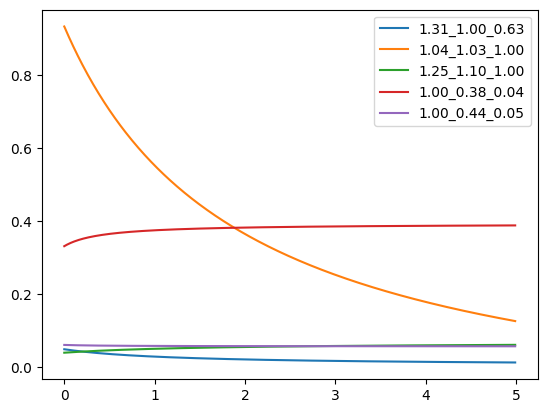

In [60]:
from scipy.optimize import minimize
x_data = np.array(sub_sub_df.index)
alist=np.arange(0., 5., 0.01)
for idx in x_data[:5]:
    true_z = sub_df.loc[idx, 'True redshift']
    pointEst_df_ev = pd.DataFrame(posteriors_dict_test[idx]['5 most likely models'])
    
    def weighted_point_est(abc):
        a,b,c = abc
        a1 = a*pointEst_df_ev.loc[0, 'Odd ratio']
        b1 = b*pointEst_df_ev.loc[1, 'Odd ratio']
        c1 = c*pointEst_df_ev.loc[2, 'Odd ratio']
        z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
        bias = np.abs(true_z-z_pointEst)
        return bias
    
    #res = minimize(weighted_point_est, (1.,1.,1.))
    #print(res)
    
    biases = [weighted_point_est((a,1.,1.)) for a in alist]
    
    plt.plot(alist, biases, label=f"{pointEst_df_ev.loc[0, 'Odd ratio']:.2f}_{pointEst_df_ev.loc[1, 'Odd ratio']:.2f}_{pointEst_df_ev.loc[2, 'Odd ratio']:.2f}")
plt.legend()

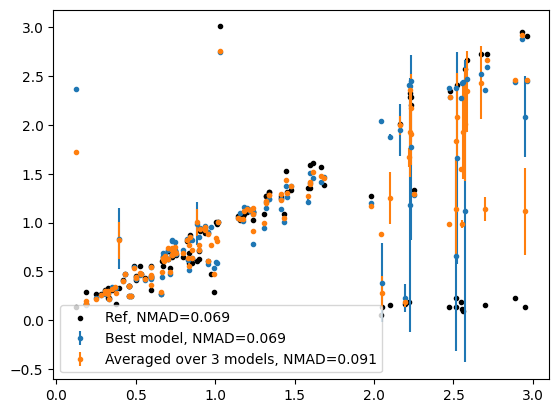

In [61]:
new_pe_z = []
new_pe_sig = []
best_mod_pe = []
best_mod_sig = []
for idx in x_data:
    pointEst_df_ev = pd.DataFrame(posteriors_dict_test[idx]['5 most likely models'])
    a1 = pointEst_df_ev.loc[0, 'Odd ratio']
    b1 = pointEst_df_ev.loc[1, 'Odd ratio']
    c1 = pointEst_df_ev.loc[2, 'Odd ratio']
    z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
    bias = np.abs(true_z-z_pointEst)
    
    var_pointEst = np.power(a1*pointEst_df_ev.loc[0, 'sigma(z)']/(a1+b1+c1), 2.)\
                    + np.power(b1*pointEst_df_ev.loc[1, 'sigma(z)']/(a1+b1+c1), 2.)\
                    + np.power(c1*pointEst_df_ev.loc[2, 'sigma(z)']/(a1+b1+c1), 2.)
    
    best_mod_pe.append(pointEst_df_ev.loc[0, 'average(z)'])
    best_mod_sig.append(pointEst_df_ev.loc[0, 'sigma(z)'])
    
    new_pe_z.append(z_pointEst)
    new_pe_sig.append(var_pointEst**0.5)

med = np.median(sub_sub_df['True redshift'].values)    

scat_ref = np.abs(sub_sub_df['Photometric redshift'].values-sub_sub_df['True redshift'].values)/(1+sub_sub_df['True redshift'].values)
scat_bm = np.abs(best_mod_pe-sub_sub_df['True redshift'].values)/(1+sub_sub_df['True redshift'].values)
scat_npe = np.abs(new_pe_z-sub_sub_df['True redshift'].values)/(1+sub_sub_df['True redshift'].values)

NMAD_ref = 1.4826 * np.median(scat_ref)
NMAD_bm = 1.4826 * np.median(scat_bm)
NMAD_npe = 1.4826 * np.median(scat_npe)

plt.scatter(sub_sub_df['True redshift'].values, sub_sub_df['Photometric redshift'].values, marker=".", c='k', label=f"Ref, NMAD={NMAD_ref:.3f}")
plt.errorbar(sub_sub_df['True redshift'].values, best_mod_pe, yerr=best_mod_sig, fmt=".", label=f"Best model, NMAD={NMAD_bm:.3f}")
plt.errorbar(sub_sub_df['True redshift'].values, new_pe_z, yerr=new_pe_sig, fmt=".", label=f"Averaged over 3 models, NMAD={NMAD_npe:.3f}")
plt.legend()

## Rank of best model at $z_{spec}$

### Re-compute the evidences

In [62]:
# Include evidence-derived properties
_case = id_test_pointEst
probsarr = posteriors_dict_test[_case]['Full posterior']
evs_nosplit = Analysis.evidence(probsarr, len(extlaws_dict_test), z_grid_test, split_laws=False)
sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
sorted_evs.reverse()
print(sorted_evs[1])

(DeviceArray(13, dtype=int32), DeviceArray(11, dtype=int32))


### Identify the coordinates of z-spec model

In [63]:
good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])

mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
for idust, d in enumerate(dust_arr_test):
    if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]

print((mod_num, dust_num, z_num))

(13, 11, 111)


### Cros-match to find rank

In [64]:
found=[t==mod_num and d==dust_num for (t,d) in sorted_evs]
np.argwhere(found)[0][0]

1

### Histogram

100%|██████████| 955/955 [09:50<00:00,  1.62it/s]


(array([930.,  10.,   6.,   6.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([  0. ,  26.4,  52.8,  79.2, 105.6, 132. , 158.4, 184.8, 211.2,
        237.6, 264. ]),
 <BarContainer object of 10 artists>)

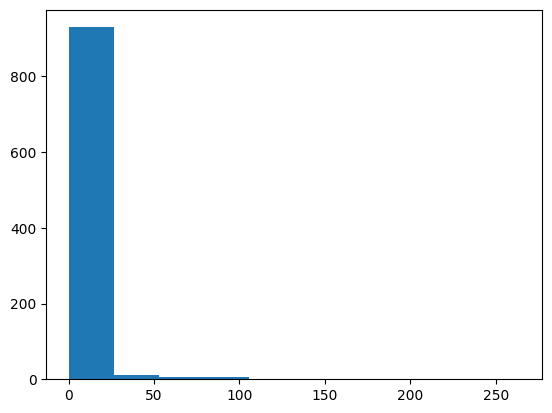

In [65]:
ranks=[]
for _case in tqdm(sub_df.index):
    probsarr = posteriors_dict_test[_case]['Full posterior']
    evs_nosplit = Analysis.evidence(probsarr, len(extlaws_dict_test), z_grid_test, split_laws=False)
    sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
    sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
    sorted_evs.reverse()
    
    good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])

    mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
    found=[t==mod_num and d==dust_num for (t,d) in sorted_evs]
    ranks.append(np.argwhere(found)[0][0])
    
#plt.hist(ranks)

<AxesSubplot:ylabel='Count'>

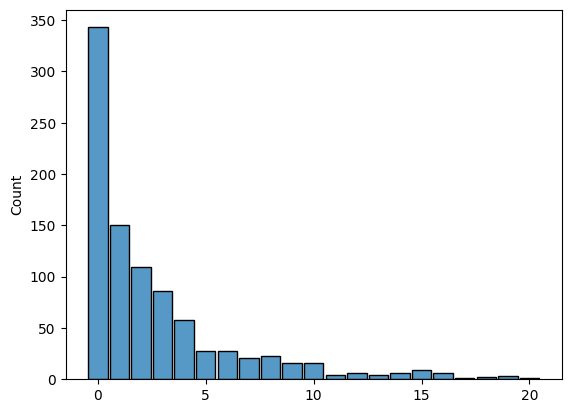

In [66]:
sns.histplot(x=ranks, discrete=True, binrange=(0,20), shrink=0.9)

100%|██████████| 955/955 [09:45<00:00,  1.63it/s]


<AxesSubplot:ylabel='Count'>

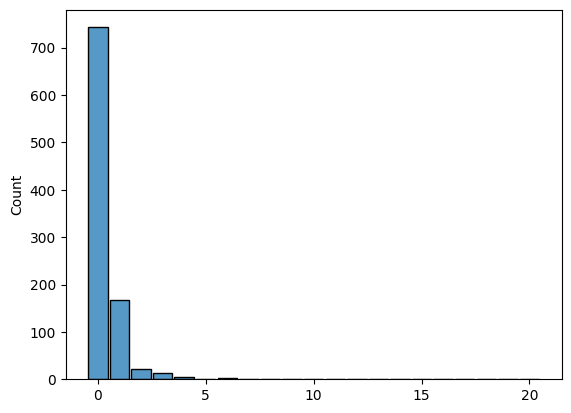

In [68]:
ranks_zp=[]
for _case in tqdm(sub_df.index):
    probsarr = posteriors_dict_test[_case]['Full posterior']
    evs_nosplit = Analysis.evidence(probsarr, len(extlaws_dict_test), z_grid_test, split_laws=False)
    sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
    sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
    sorted_evs.reverse()

    mod_num=np.argwhere(temp_names == sub_df.loc[_case, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==sub_df.loc[_case, 'Extinction law'] and d.EBV==sub_df.loc[_case, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-sub_df.loc[_case, 'Photometric redshift'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
    found=[t==mod_num and d==dust_num for (t,d) in sorted_evs]
    ranks_zp.append(np.argwhere(found)[0][0])
    
#sns.histplot(x=ranks_zp, discrete=True, binrange=(0,20), shrink=0.9)

### Rank of $min(\chi^2)$ model in terms of $z_{spec}$

100%|██████████| 955/955 [12:30<00:00,  1.27it/s]  


<AxesSubplot:ylabel='Count'>

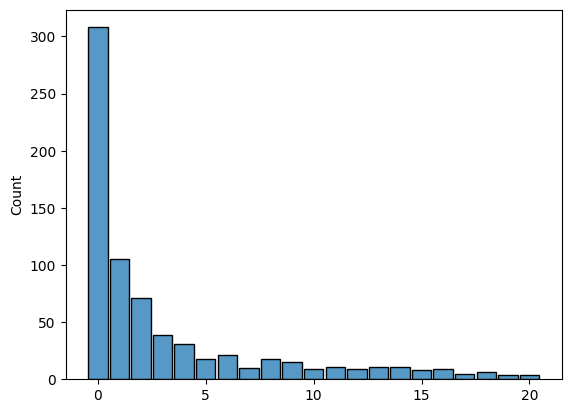

In [69]:
ranks_at_zs=[]
for _case in tqdm(sub_df.index):
    if jnp.isfinite(sub_df.loc[_case, 'True redshift']):
        zs=sub_df.loc[_case, 'True redshift']
        probsarr = posteriors_dict_test[_case]['Full posterior']
        if len(extlaws_dict_test)==1 and len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_noDust(probsarr, zs, len(baseTemp_arr_test), z_grid_test,\
                                                                  renormalize=True, prenormalize=False)
        elif len(extlaws_dict_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneLaw(probsarr, zs, len(baseTemp_arr_test),\
                                                                  ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        elif len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneEBV(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                                  z_grid_test, renormalize=True, prenormalize=False)
        else:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                           ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        sorted_pzfix_flat = jnp.argsort(p_zfix_nosplit, axis=None)
        sorted_pzfix = [ jnp.unravel_index(idx, p_zfix_nosplit.shape) for idx in sorted_pzfix_flat ]
        sorted_pzfix.reverse()
        
        mod_num=np.argwhere(temp_names == sub_df.loc[_case, 'Template SED'])[0][0]
        for idust, d in enumerate(dust_arr_test):
            if d.name==sub_df.loc[_case, 'Extinction law'] and d.EBV==sub_df.loc[_case, 'E(B-V)'] : dust_num = idust
        z_num = np.argwhere(np.abs(z_grid_test-sub_df.loc[_case, 'Photometric redshift'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
        found=[t==mod_num and d==dust_num for (t,d) in sorted_pzfix]
        ranks_at_zs.append(np.argwhere(found)[0][0])
    
#sns.histplot(x=ranks_at_zs, discrete=True, binrange=(0,20), shrink=0.9)

100%|██████████| 955/955 [09:56<00:00,  1.60it/s]


<AxesSubplot:ylabel='Count'>

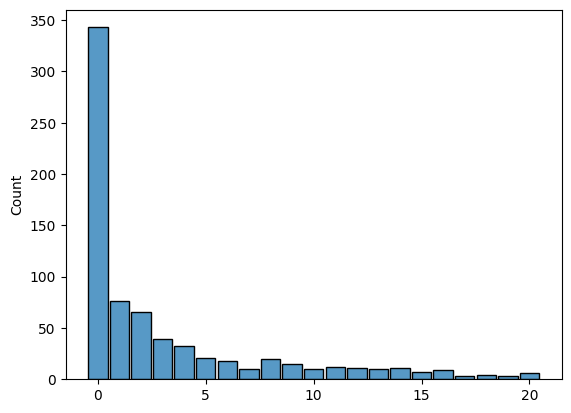

In [89]:
ranks_ev_at_zs=[]
for _case in tqdm(sub_df.index):
    if jnp.isfinite(sub_df.loc[_case, 'True redshift']):
        zs=sub_df.loc[_case, 'True redshift']
        probsarr = posteriors_dict_test[_case]['Full posterior']
        if len(extlaws_dict_test)==1 and len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_noDust(probsarr, zs, len(baseTemp_arr_test), z_grid_test,\
                                                                  renormalize=True, prenormalize=False)
        elif len(extlaws_dict_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneLaw(probsarr, zs, len(baseTemp_arr_test),\
                                                                  ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        elif len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneEBV(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                                  z_grid_test, renormalize=True, prenormalize=False)
        else:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                           ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        sorted_pzfix_flat = jnp.argsort(p_zfix_nosplit, axis=None)
        sorted_pzfix = [ jnp.unravel_index(idx, p_zfix_nosplit.shape) for idx in sorted_pzfix_flat ]
        sorted_pzfix.reverse()
        
        mod_num=np.argwhere(temp_names == sub_df.loc[_case, 'Highest evidence SED'])[0][0]
        for idust, d in enumerate(dust_arr_test):
            if d.name==sub_df.loc[_case, 'Highest evidence dust law'] and d.EBV==sub_df.loc[_case, 'Highest evidence E(B-V)'] : dust_num = idust
        z_num = np.argwhere(np.abs(z_grid_test-sub_df.loc[_case, 'Photometric redshift'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
        found=[t==mod_num and d==dust_num for (t,d) in sorted_pzfix]
        ranks_ev_at_zs.append(np.argwhere(found)[0][0])
    
#sns.histplot(x=ranks_ev_at_zs, discrete=True, binrange=(0,20), shrink=0.9)

In [71]:
sub_df['photo-z model ranking at z_spec']=np.array(ranks_at_zs)

/tmp/ipykernel_3309/2852833274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['photo-z model ranking at z_spec']=np.array(ranks_at_zs)


<AxesSubplot:xlabel='photo-z model ranking at z_spec', ylabel='Count'>

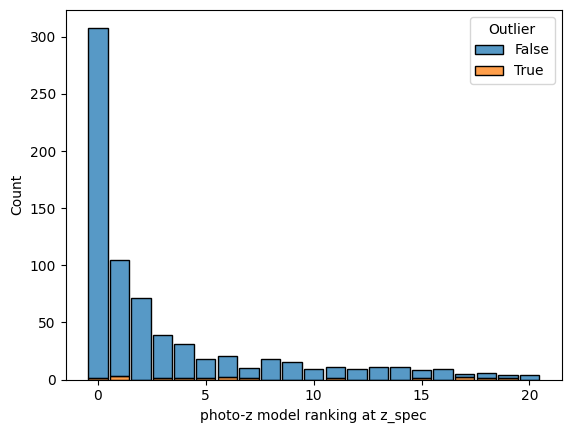

In [91]:
sns.histplot(data=sub_df, x='photo-z model ranking at z_spec', hue='Outlier', discrete=True, binrange=(0,20), shrink=0.9, multiple='stack')

/tmp/ipykernel_3309/1501437297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Highest evidence model ranking at z_spec']=np.array(ranks_ev_at_zs)


<AxesSubplot:xlabel='Highest evidence model ranking at z_spec', ylabel='Count'>

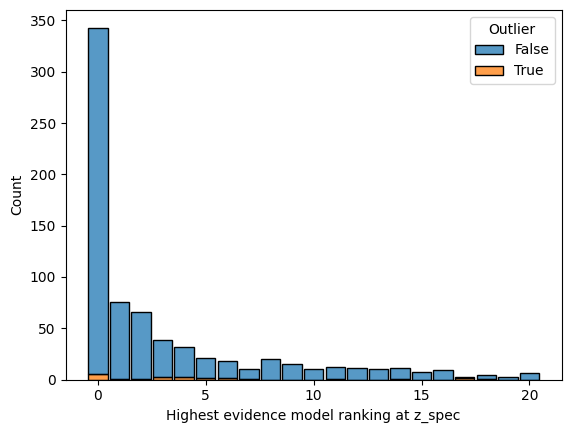

In [94]:
sub_df['Highest evidence model ranking at z_spec']=np.array(ranks_ev_at_zs)
sns.histplot(data=sub_df, x='Highest evidence model ranking at z_spec', hue='Outlier', discrete=True, binrange=(0,20), shrink=0.9, multiple='stack')

<AxesSubplot:ylabel='Count'>

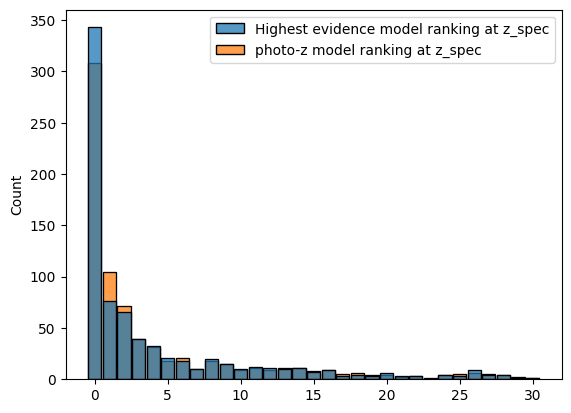

In [111]:
f,a=plt.subplots(1,1)
plot_df = sub_df[['Highest evidence model ranking at z_spec', 'photo-z model ranking at z_spec']].copy()
sns.histplot(data=plot_df, discrete=True, binrange=(0,30), shrink=0.9, multiple='stack', ax=a, element='bars', cumulative=False)

/tmp/ipykernel_3309/3333230702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Ranking of best model at z_spec']=np.array(ranks)


<AxesSubplot:xlabel='Ranking of best model at z_spec', ylabel='Count'>

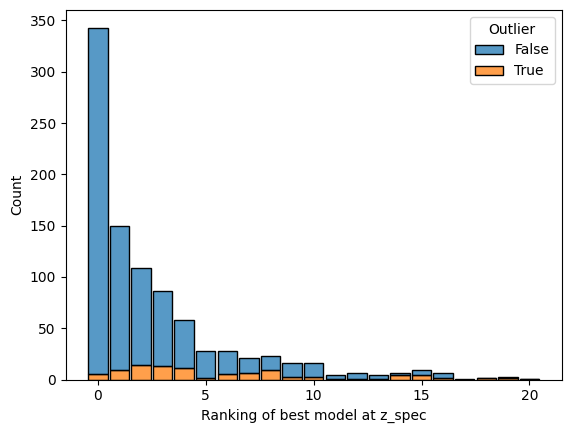

In [74]:
sub_df['Ranking of best model at z_spec']=np.array(ranks)
sns.histplot(data=sub_df, x='Ranking of best model at z_spec', hue='Outlier', discrete=True, binrange=(0,20), shrink=0.9, multiple='stack')

In [75]:
from pysankey import sankey

In [76]:
sub_df.columns

Index(['Id', 'Photometric redshift', 'True redshift', 'Template SED',
       'Extinction law', 'E(B-V)', 'Chi2', 'Highest evidence SED',
       'Highest evidence dust law', 'Highest evidence E(B-V)',
       'Highest evidence odd ratio', 'Highest evidence z_phot (mode)',
       'Highest evidence z_phot (mean)', 'Highest evidence sigma(z)',
       'Best SED at z_spec', 'Best dust law at z_spec', 'E(B-V) at z_spec',
       'Mode of best model at z_spec', 'Mean of best model at z_spec',
       'Odd ratio of best model at z_spec', 'MagAB(cosmos_u_cfht)',
       'err_MagAB(cosmos_u_cfht)', 'MagAB(cosmos_u_new)',
       'err_MagAB(cosmos_u_new)', 'MagAB(hsc_gHSC)', 'err_MagAB(hsc_gHSC)',
       'MagAB(hsc_rHSC)', 'err_MagAB(hsc_rHSC)', 'MagAB(hsc_iHSC)',
       'err_MagAB(hsc_iHSC)', 'MagAB(hsc_zHSC)', 'err_MagAB(hsc_zHSC)',
       'MagAB(hsc_yHSC)', 'err_MagAB(hsc_yHSC)', 'Bias', 'Outlier', 'U-B',
       'R-I', 'Best estimator', 'Best point estimate',
       'Best estimator at z_spec', 'Best

<AxesSubplot:>

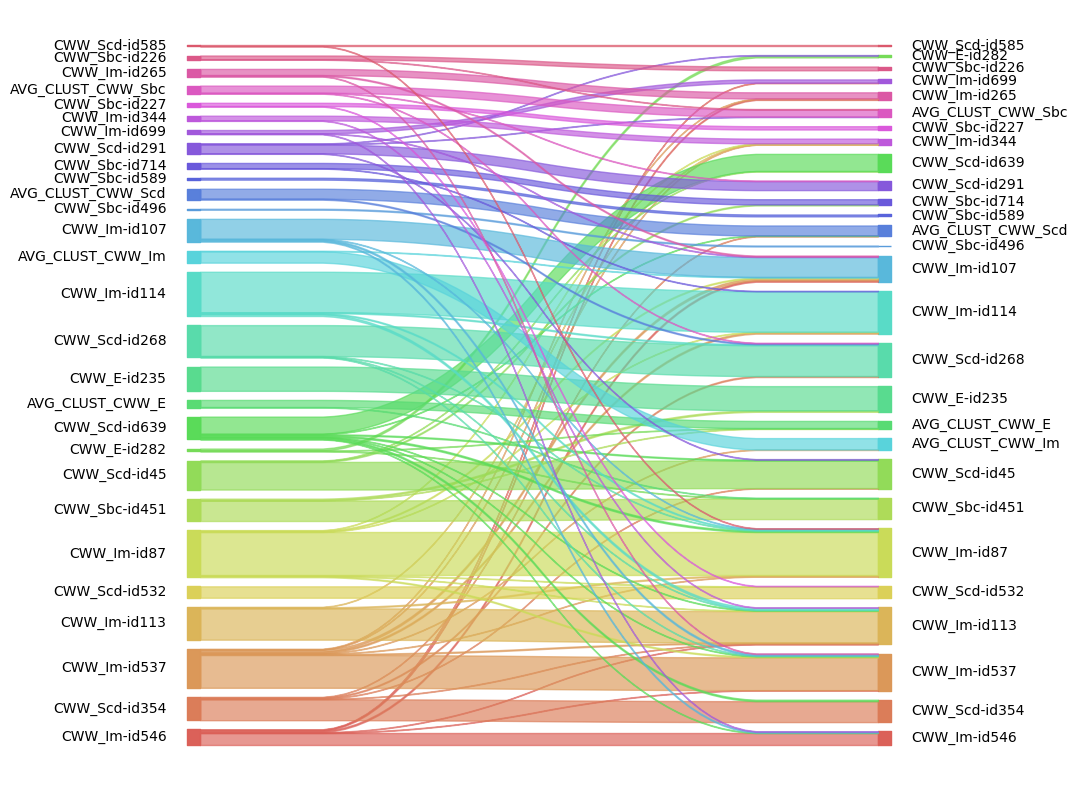

In [77]:
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(sub_df['Template SED'], sub_df['Highest evidence SED'], fontsize=10, ax=a)

<AxesSubplot:>

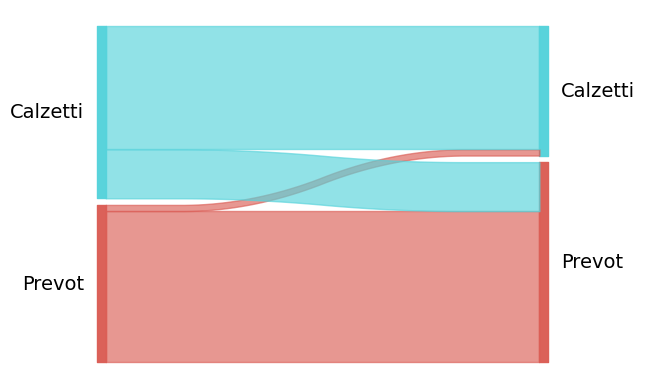

In [78]:
sankey(sub_df['Extinction law'], sub_df['Highest evidence dust law'])

<AxesSubplot:>

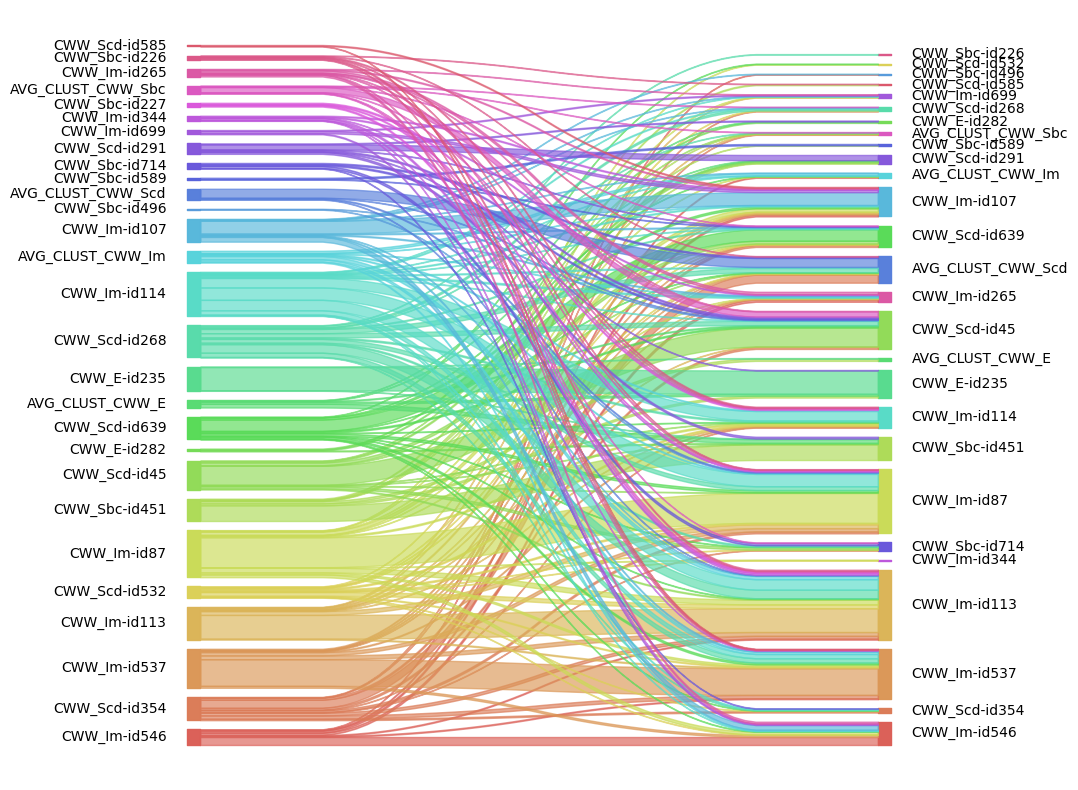

In [79]:
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(sub_df['Template SED'], sub_df['Best SED at z_spec'], fontsize=10, ax=a)

<AxesSubplot:>

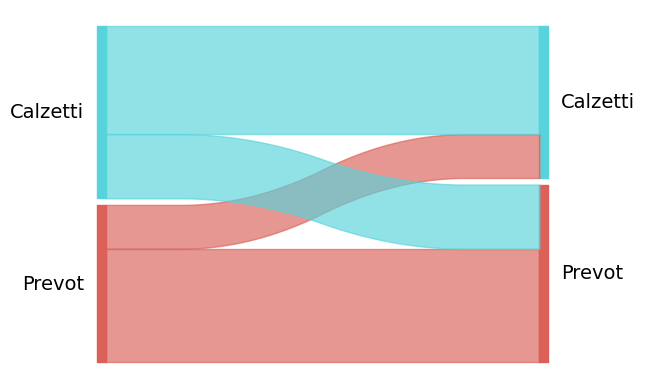

In [80]:
sankey(sub_df['Extinction law'], sub_df['Best dust law at z_spec'])

<AxesSubplot:>

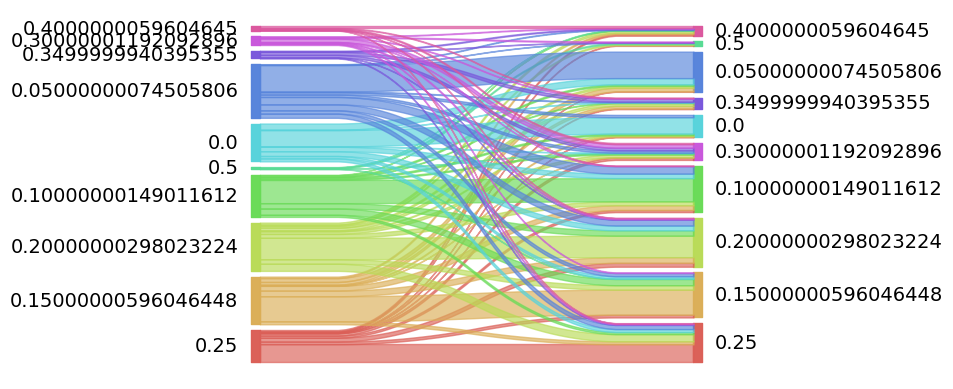

In [81]:
sankey(sub_df['E(B-V)'], sub_df['E(B-V) at z_spec'])

<AxesSubplot:>

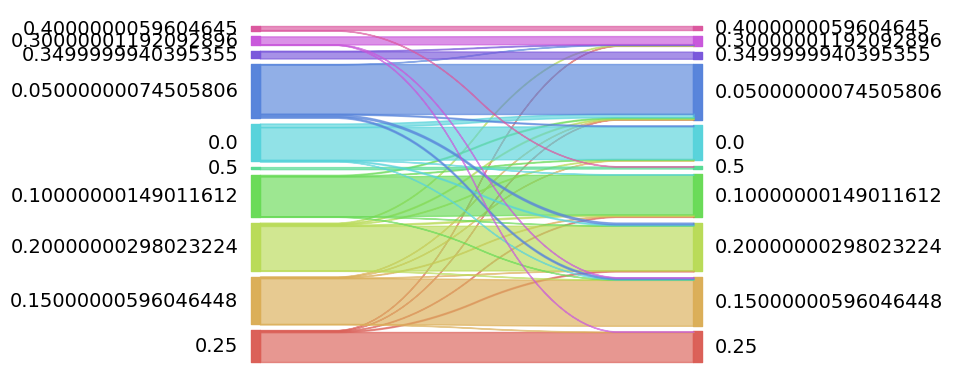

In [82]:
sankey(sub_df['E(B-V)'], sub_df['Highest evidence E(B-V)'])

<AxesSubplot:>

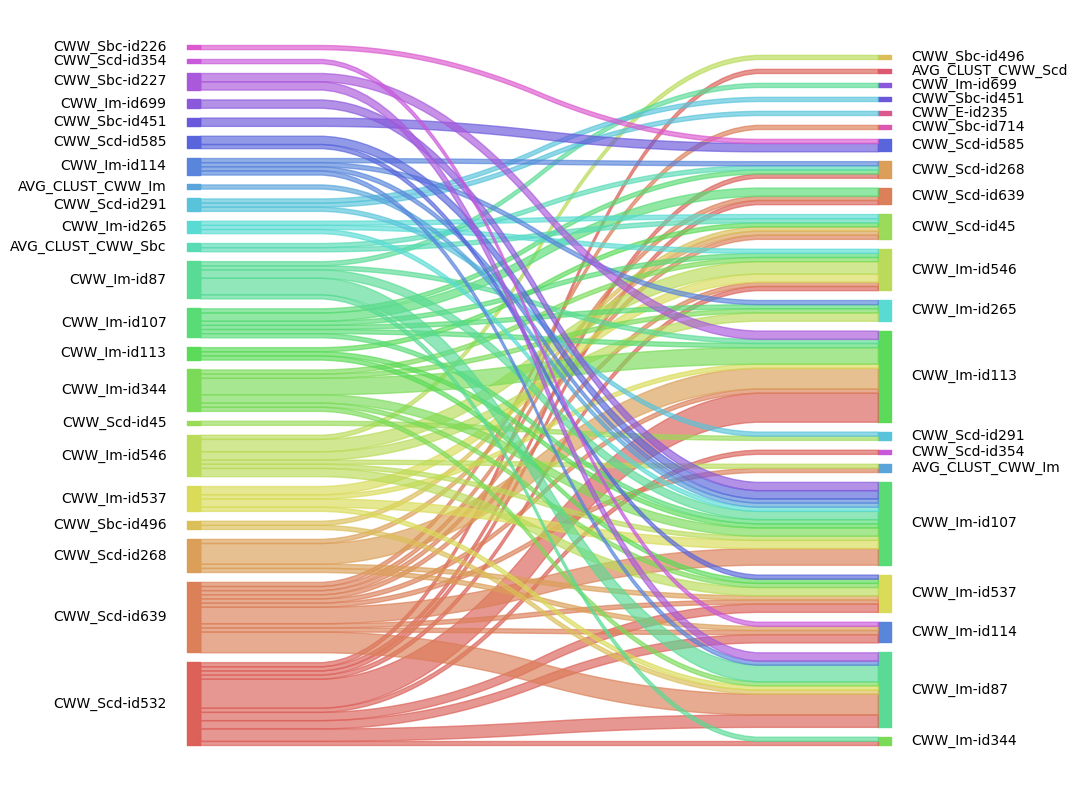

In [83]:
outliers_df = sub_df[sub_df['Outlier']]
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(outliers_df['Template SED'], outliers_df['Best SED at z_spec'], fontsize=10, ax=a)

<AxesSubplot:>

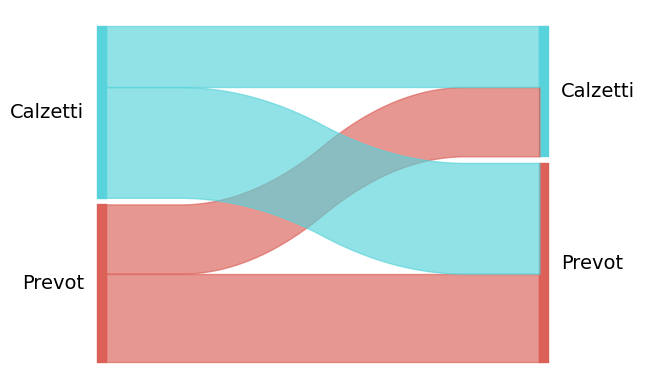

In [84]:
sankey(outliers_df['Extinction law'], outliers_df['Best dust law at z_spec'])

<AxesSubplot:>

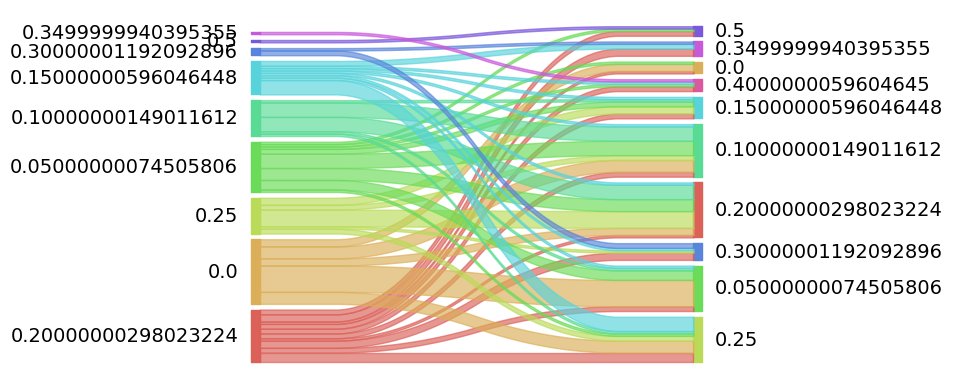

In [85]:
sankey(outliers_df['E(B-V)'], outliers_df['E(B-V) at z_spec'])

<AxesSubplot:>

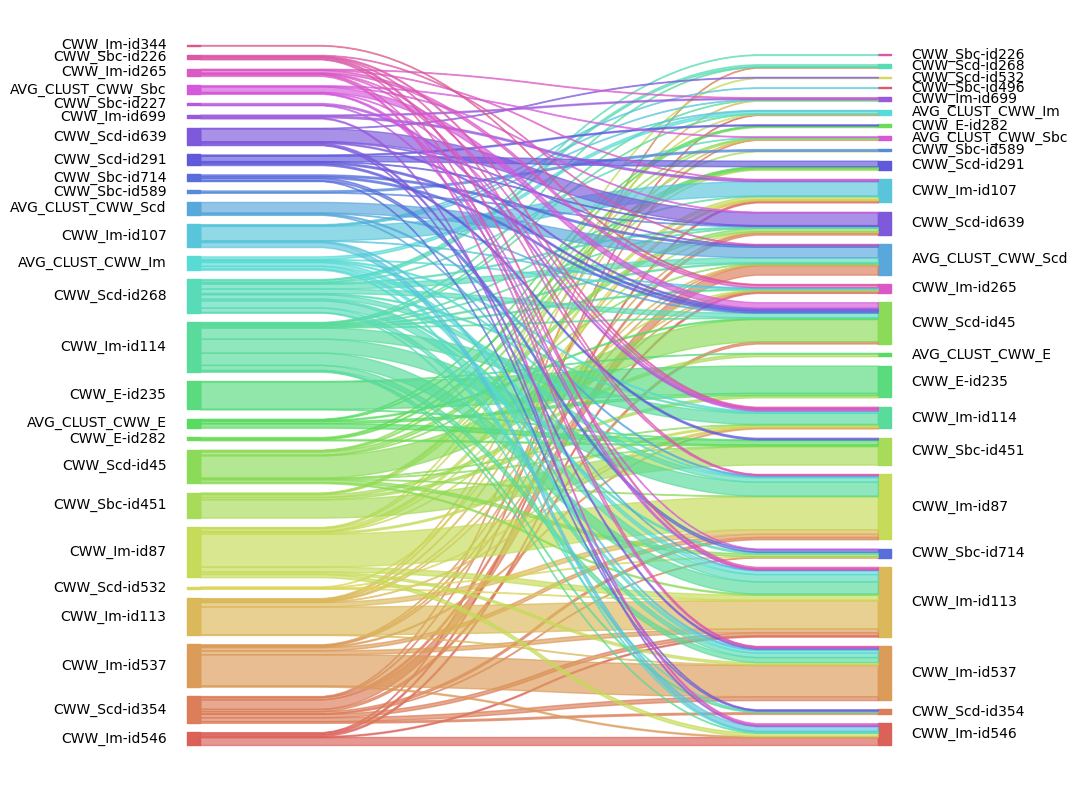

In [86]:
insiders_df = sub_df[[not b for b in sub_df['Outlier']]]
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(insiders_df['Template SED'], insiders_df['Best SED at z_spec'], fontsize=10, ax=a)

<AxesSubplot:>

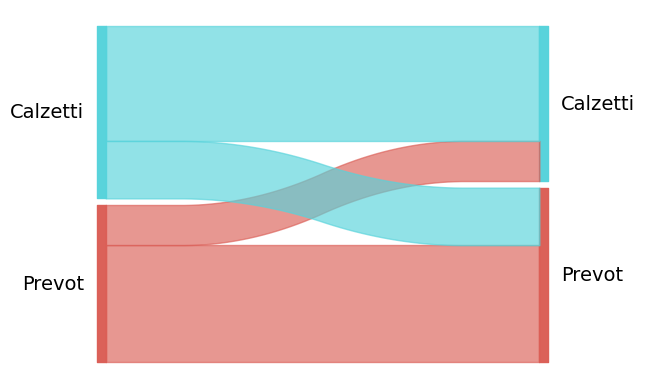

In [87]:
sankey(insiders_df['Extinction law'], insiders_df['Best dust law at z_spec'])

<AxesSubplot:>

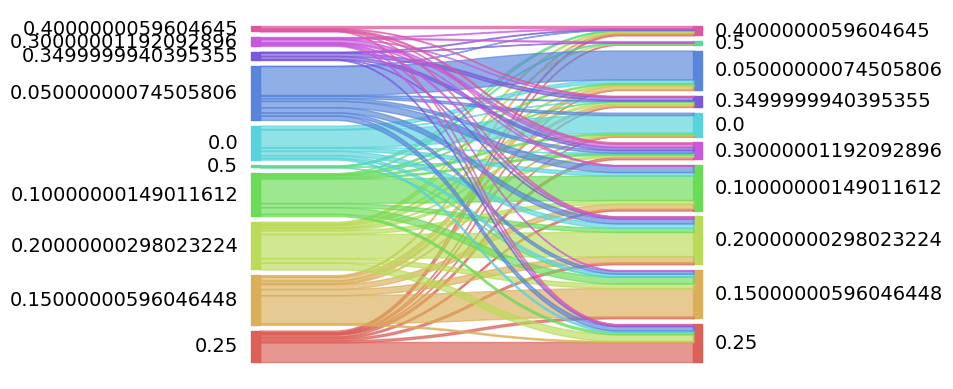

In [88]:
sankey(insiders_df['E(B-V)'], insiders_df['E(B-V) at z_spec'])

Pas de conclusion à propos de E(B-V) ni loi de poussière, par contre certaines templates peuvent être exclues par ce genre de procédé car très peu présentes dans les bons modèles à z_spec 